In [1]:
#Import Dependencies
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import Sequential, layers, callbacks, optimizers
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
#Preprocessing utils
def correlation_plot(source):
    corr = source.corr(numeric_only = True)

    plt.figure(figsize = (20, 8))
    sns.heatmap(corr, cmap = "YlGnBu", annot = True)
    plt.show()

def split_dataset(source, target = "NObeyesdad"):
    data_dir = "/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/"
    
    
    X = source.drop(columns=[target])
    y = source[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size = 0.3,
        random_state = 42,
        stratify = y
    )

    X_train.to_csv(data_dir + "X_train.csv", index=False)
    X_test.to_csv(data_dir + "X_test.csv", index=False)
    y_train.to_csv(data_dir + "y_train.csv", index=False)
    y_test.to_csv(data_dir + "y_test.csv", index=False)

    print("Train set size:", X_train.shape)
    print("Test set size:", X_test.shape)
    
def outliers_plot(df):
    numeric_features = df.select_dtypes(include = ['int64', 'float64']).columns
    
    for col in numeric_features:
        plt.figure(figsize = (8, 4))
        sns.boxplot(x = df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

def outliers_summary(df):
    numeric_cols = df.select_dtypes(include = ['int64', 'float64']).columns

    print("Outlier Summary per Numeric Feature:\n")
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        count = outliers.shape[0]

        print(f"{col}: {count} outlier(s)")
        if count > 0:
            print("Values:", outliers.values)
        print("-" * 50)

def scale_minmax(X_train, X_test, features):
    scaler = MinMaxScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    scaler.fit(X_train[features])

    X_train_scaled[features] = scaler.transform(X_train[features])
    X_test_scaled[features] = scaler.transform(X_test[features])

    return X_train_scaled, X_test_scaled

def scale_standard(X_train, X_test, features):
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    scaler.fit(X_train[features])
    X_train_scaled[features] = scaler.transform(X_train[features])
    X_test_scaled[features] = scaler.transform(X_test[features])
    
    return X_train_scaled, X_test_scaled

def scale_robust(X_train, X_test, features):
    scaler = RobustScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    scaler.fit(X_train[features])
    X_train_scaled[features] = scaler.transform(X_train[features])
    X_test_scaled[features] = scaler.transform(X_test[features])
    
    return X_train_scaled, X_test_scaled

In [3]:
#Classical model utils

def knn_predict():
    boss_knn = None
    boss_y = None
    boss_k = None
    max_accuracy = float("-inf")

    for k in range(1, 31):
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)

        if accuracy > max_accuracy:
            boss_y = y_pred
            max_accuracy = accuracy
            boss_k = k
            boss_knn = knn

    print("Best value of K is", boss_k)
    return boss_knn, boss_y, max_accuracy

def nb_predict():
    nb = GaussianNB()

    nb.fit(X_train_scaled, y_train)
    y_pred = nb.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return nb, y_pred, accuracy

def dt_predict():
    dt = DecisionTreeClassifier(
    criterion = "entropy", 
    max_depth = None,
    random_state = 42
)
    dt.fit(X_train_scaled, y_train)
    y_pred = dt.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return dt, y_pred, accuracy

'''def sigmoid(z):
    return 1 / (1 + np.exp(-z))


class Logistic_Regression_GD:
    def __init__(self, lr = 0.01, epochs = 1000):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        m, n = X.shape
        self.w = np.zeros(n) #w
        self.b = 0           #beta
        self.losses = []

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.w) + self.b
            y_pred = sigmoid(linear_model)

            dw = (1/m) * np.dot(X.T, (y_pred - y))
            db = (1/m) * np.sum(y_pred - y)

            self.w -= self.lr * dw
            self.b -= self.lr * db

            loss = -(1 / m) * np.sum(y * np.log(y_pred + 1e-10) + (1-y) * np.log(1 - y_pred + 1e-10))
            self.losses.append(loss)

    def predict(self, X):
        linear_model = np.dot(X, self.w) + self.b
        y_pred = sigmoid(linear_model)
        return np.where(y_pred >= 0.5, 1, 0)

def log_predict():
    log_reg = Logistic_Regression_GD()

    log_reg.fit(X_train_scaled, y_train)
    y_pred = log_reg.predict(X_test_scaled)
    accuracy = accuracy_score(y_pred, y_test)
    return y_pred, accuracy'''


def log_predict():
    log_reg = LogisticRegression(
        solver = 'lbfgs',
        max_iter = 1000,    
        random_state = 42
    )

    log_reg.fit(X_train_scaled, y_train)
    y_pred = log_reg.predict(X_test_scaled)
    accuracy = accuracy_score(y_pred, y_test)
    return log_reg, y_pred, accuracy

# **Dataset Description**

In [4]:
source = pd.read_csv('/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/Updated_Obesity_Dataset.csv')
target_col = source.columns[-1]

In [5]:
#1 Number of features
num_features = source.shape[1] - 1
print(f"Number of features: {num_features}") 

Number of features: 16


In [6]:
# 2. Classification or regression problem?
if source[target_col].dtype == "object":
    problem_type = "Classification"
else:
    problem_type = "Regression"
print(f"Problem type: {problem_type}")

Problem type: Classification


In [7]:
# 3. How many data points?
num_data_points = source.shape[0]
print(f"Number of data points: {num_data_points}")

Number of data points: 2111


In [8]:
# 4. Type of features (Quantitative / Categorical)
feature_types = source.dtypes[:-1].apply(lambda x: "Categorical" if x == "object" else "Quantitative")
print("Feature types:\n", feature_types)

Feature types:
 Age                               Quantitative
Gender                             Categorical
Height                            Quantitative
Weight                            Quantitative
CALC                               Categorical
FAVC                               Categorical
FCVC                              Quantitative
NCP                               Quantitative
SCC                                Categorical
SMOKE                              Categorical
CH2O                              Quantitative
family_history_with_overweight     Categorical
FAF                               Quantitative
TUE                               Quantitative
CAEC                               Categorical
MTRANS                             Categorical
dtype: object


In [9]:
# 5. Do you need to encode categorical variables?
needs_encoding = any(feature_types == "Categorical")
print(f"Need to encode categorical variables?: {'Yes' if needs_encoding else 'No'}")

Need to encode categorical variables?: Yes


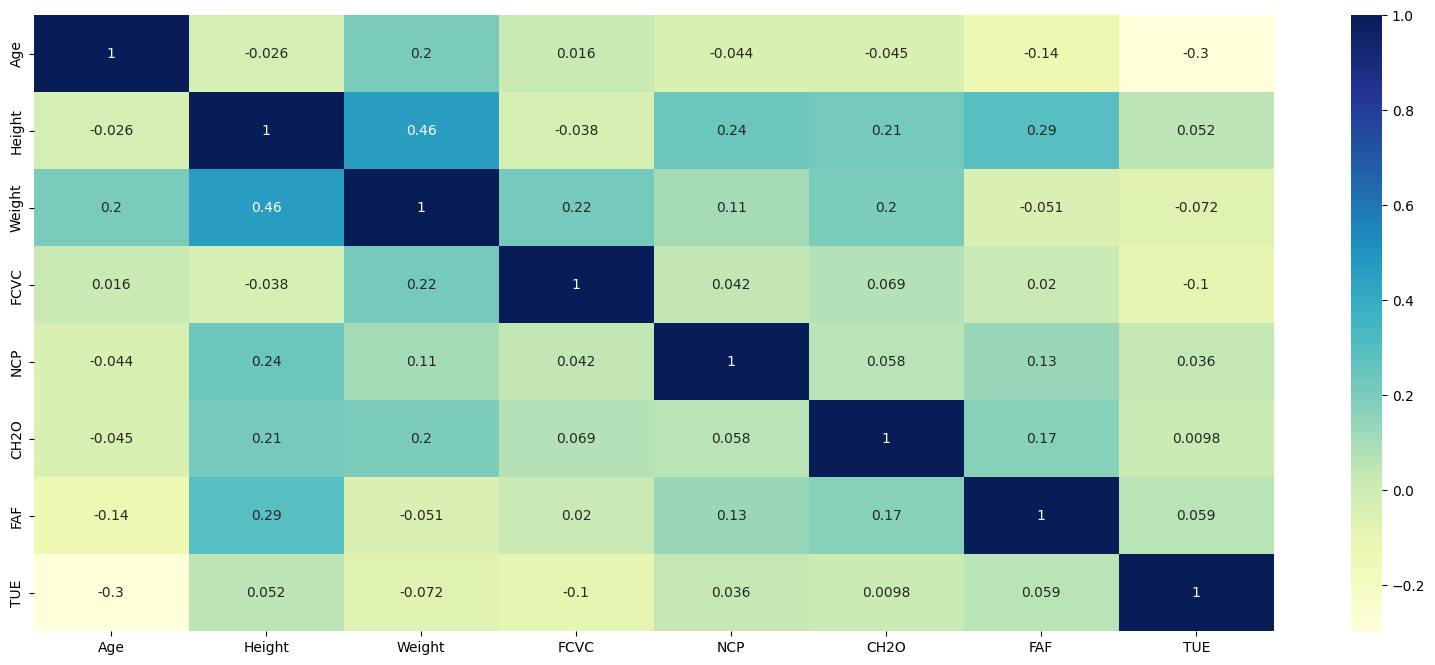

In [10]:
# 6. Correlation of all the features (input and output features)
numerical_data = source.select_dtypes(include = ['int64', 'float64'])

correlation_plot(numerical_data)

***Imbalanced Dataset***

Class distribution:
 NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64
-------------------------------------------------------------------------------------
The dataset is imbalanced: classes have different number of instances.
-------------------------------------------------------------------------------------


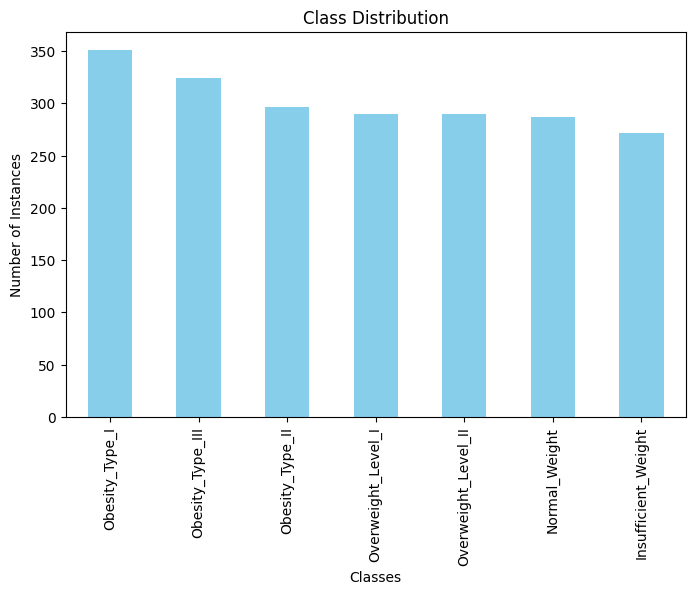

In [11]:
# Are all classes equally represented?
class_counts = source[target_col].value_counts()
print("Class distribution:\n", class_counts)

print('-' * 85)
if class_counts.nunique() == 1:
    print("The dataset is balanced: all classes have equal number of instances.")
else:
    print("The dataset is imbalanced: classes have different number of instances.")
print('-' * 85)

plt.figure(figsize = (8, 5))
class_counts.plot(kind = 'bar', color = 'skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.show()

Has to be stratified due to imbalance ^

***EDA***

In [12]:
print("Dataset Shape:", source.shape)
print("Feature Types:\n", source.dtypes)
print("Missing Values:\n", source.isnull().sum())
print("Unique Values in Categorical Features:")
for col in source.select_dtypes(include = 'object').columns:
    print(f"{col}: {source[col].nunique()} unique values")

Dataset Shape: (2111, 17)
Feature Types:
 Age                               float64
Gender                             object
Height                            float64
Weight                            float64
CALC                               object
FAVC                               object
FCVC                              float64
NCP                               float64
SCC                                object
SMOKE                              object
CH2O                              float64
family_history_with_overweight     object
FAF                               float64
TUE                               float64
CAEC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object
Missing Values:
 Age                                0
Gender                            11
Height                             0
Weight                             0
CALC                               0
FAVC                        

In [13]:
categorical_cols = source.select_dtypes(include='object').columns.drop(target_col)
categorical_features = source.select_dtypes(include = "object")
numeric_cols = source.select_dtypes(include = ['int64', 'float64']).columns
numerical_data = source.select_dtypes(include = ['int64', 'float64'])

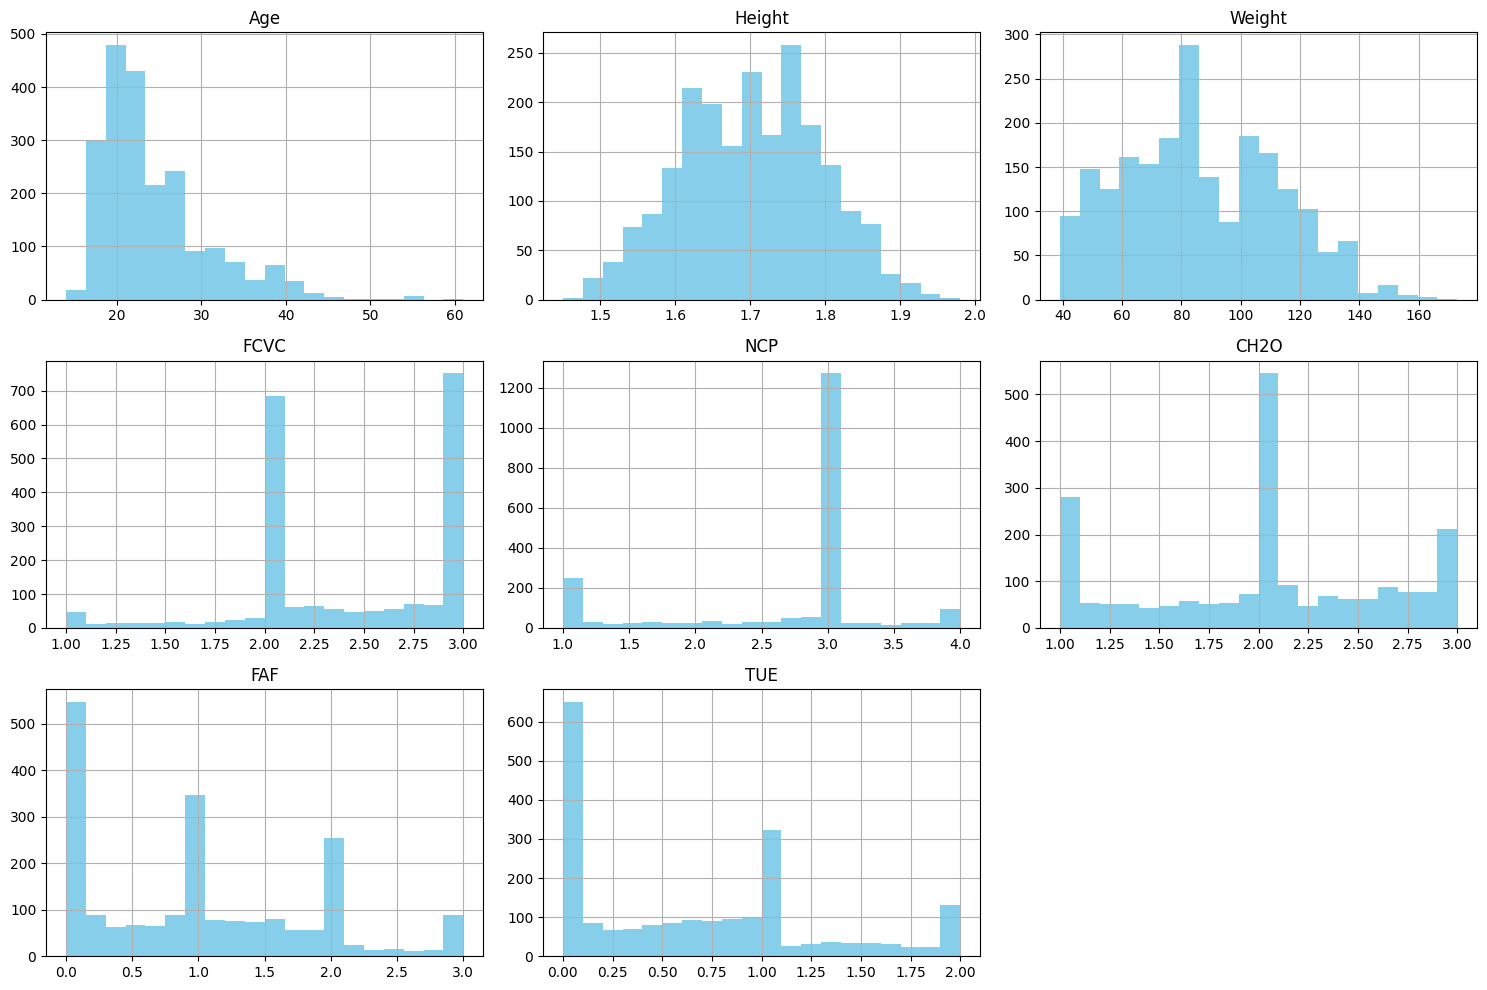

In [14]:
source[numeric_cols].hist(figsize = (15,10), bins = 20, color = 'skyblue')
plt.tight_layout()
plt.show()

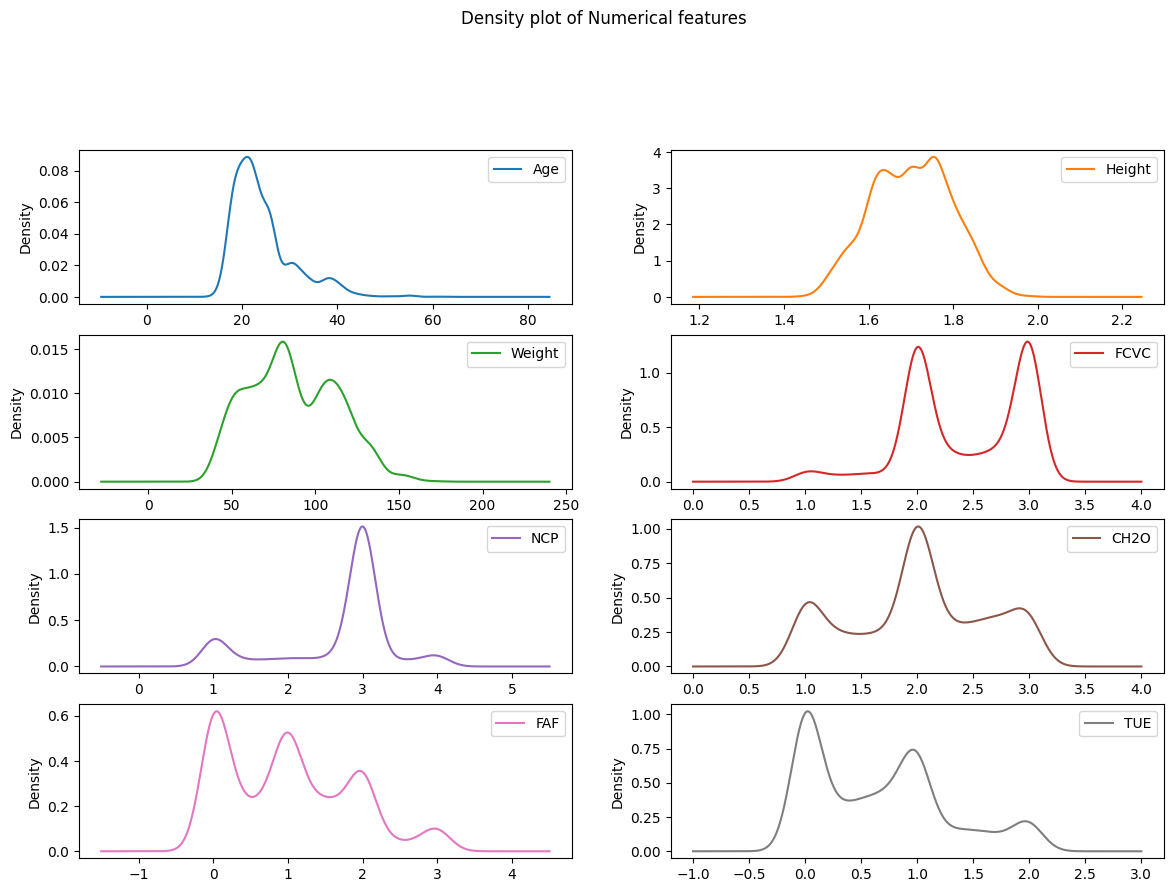

In [15]:
numerical_data.plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

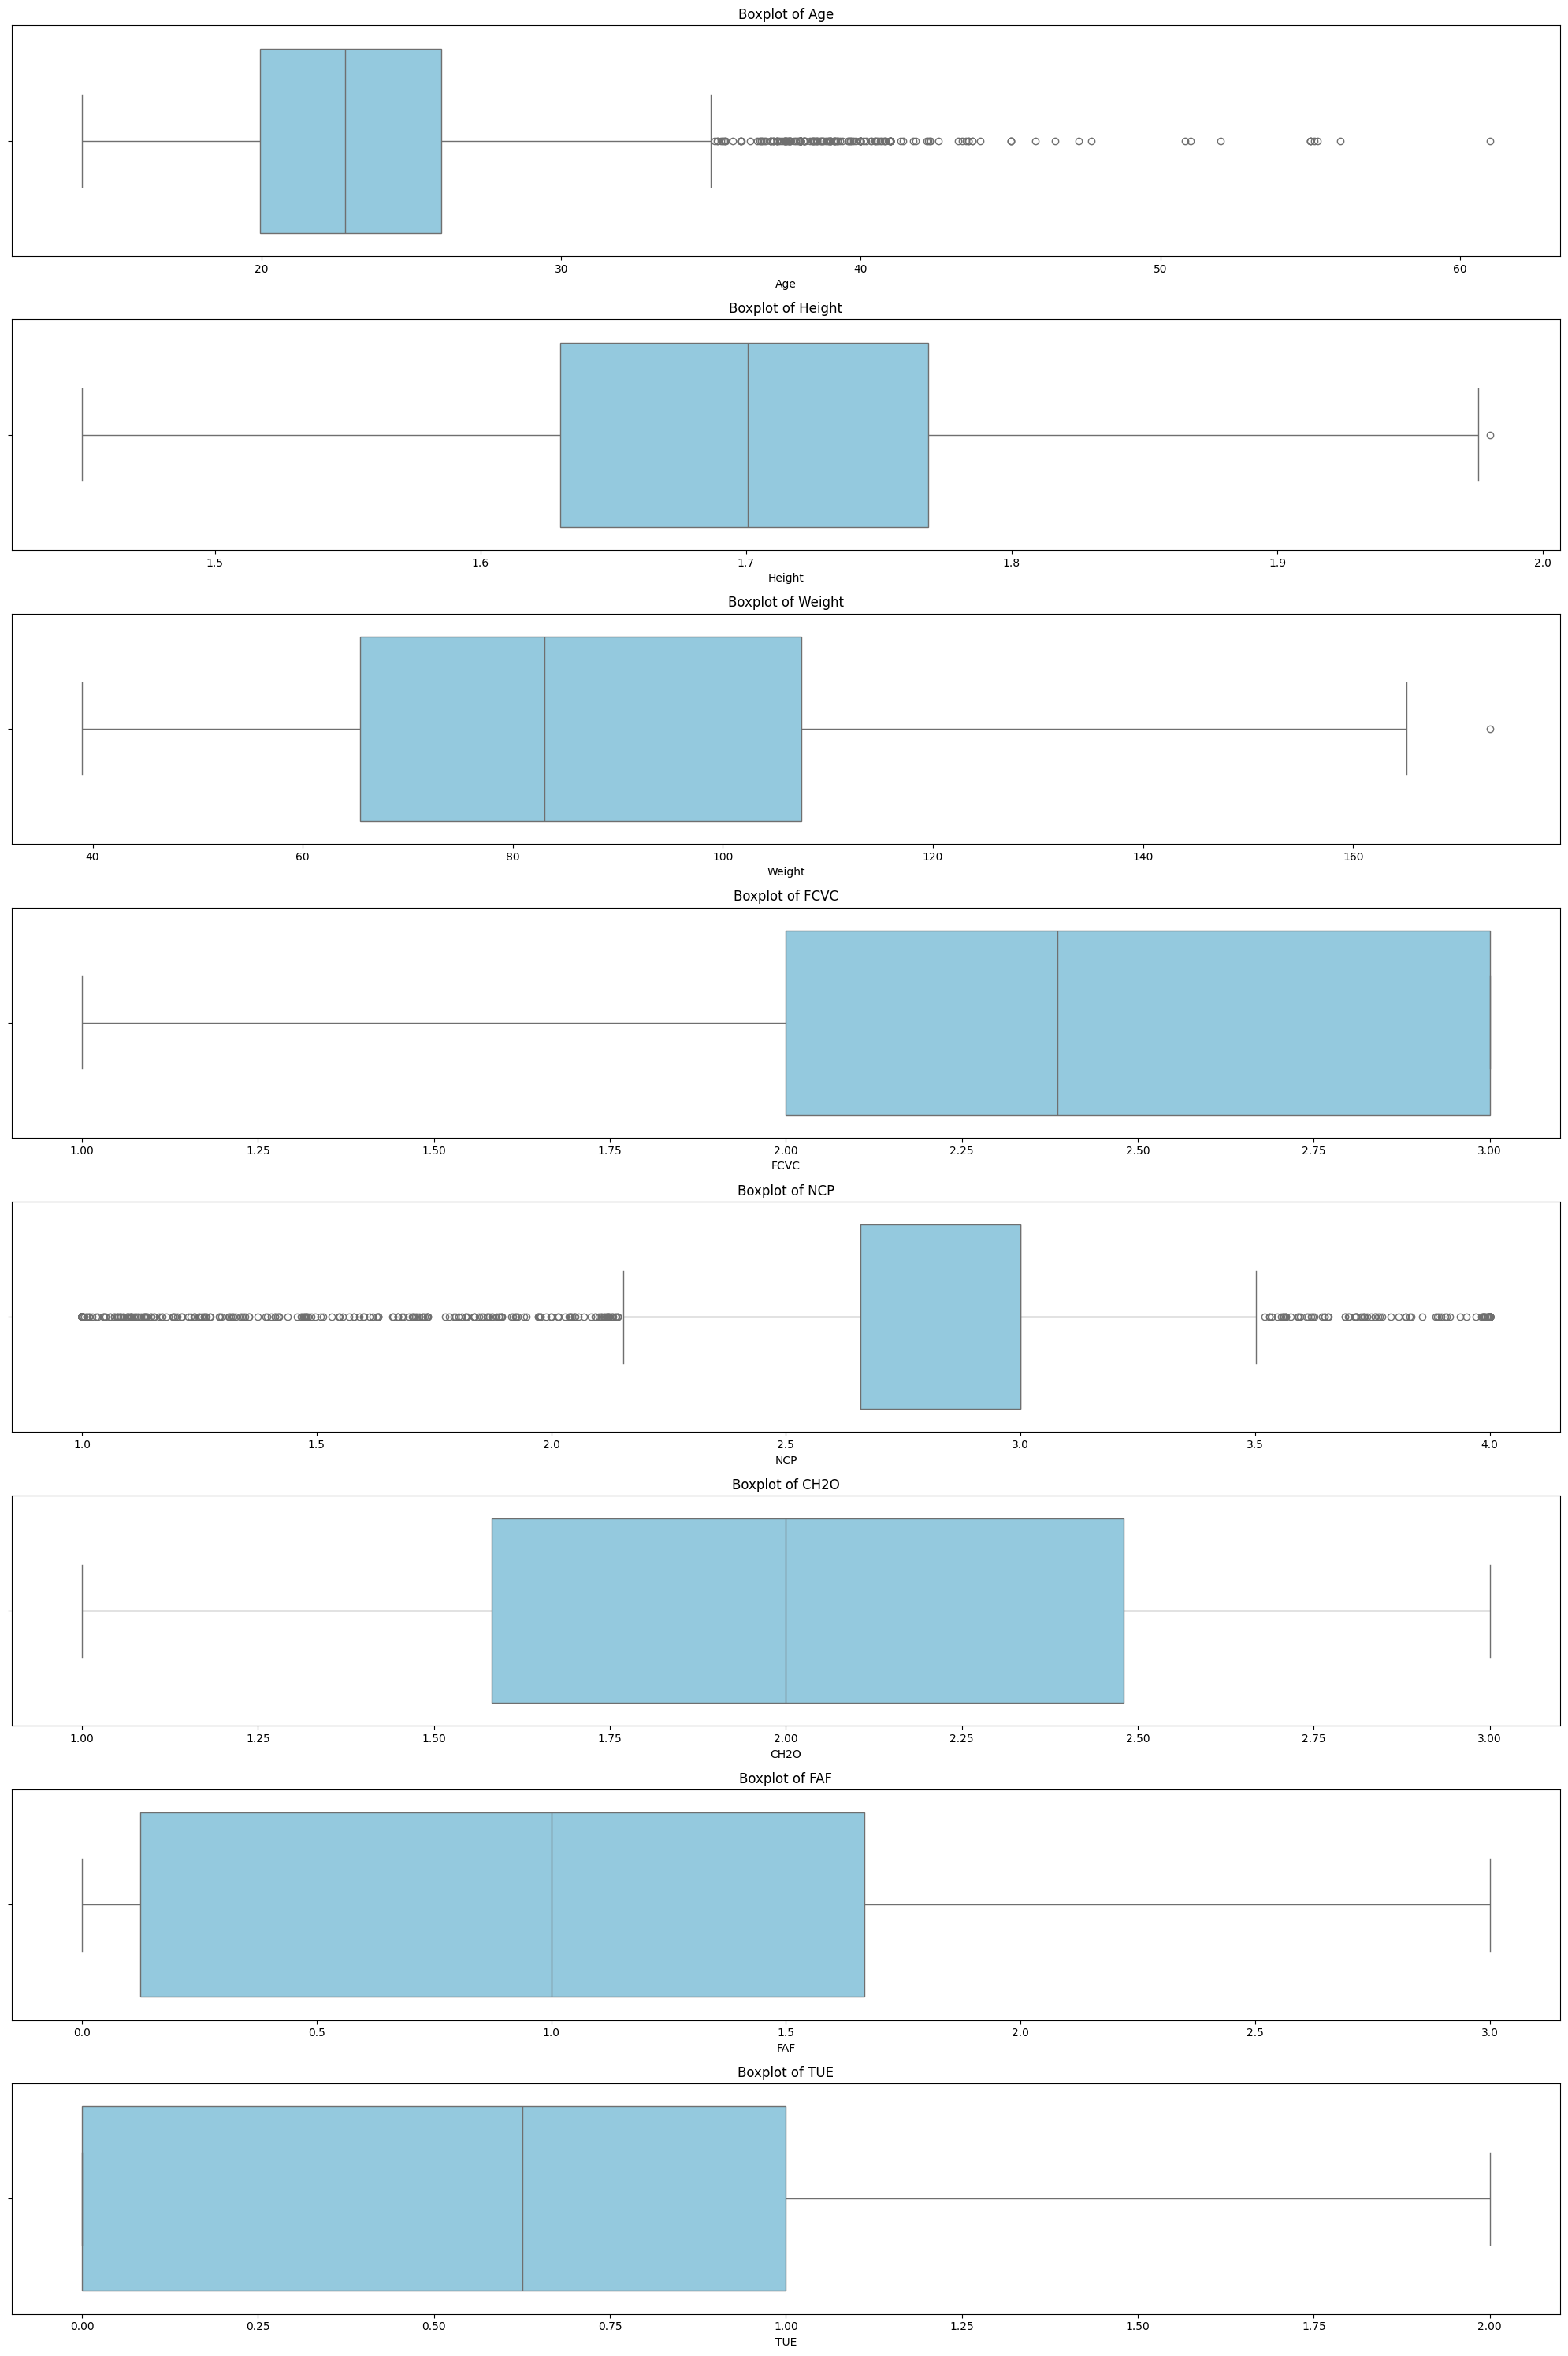

In [16]:
plt.figure(figsize = (20, 30))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x = source[col], color = 'skyblue')
    plt.title(f'Boxplot of {col}', fontsize = 12)
    plt.tight_layout()

plt.show()
#A lot of outliers in some

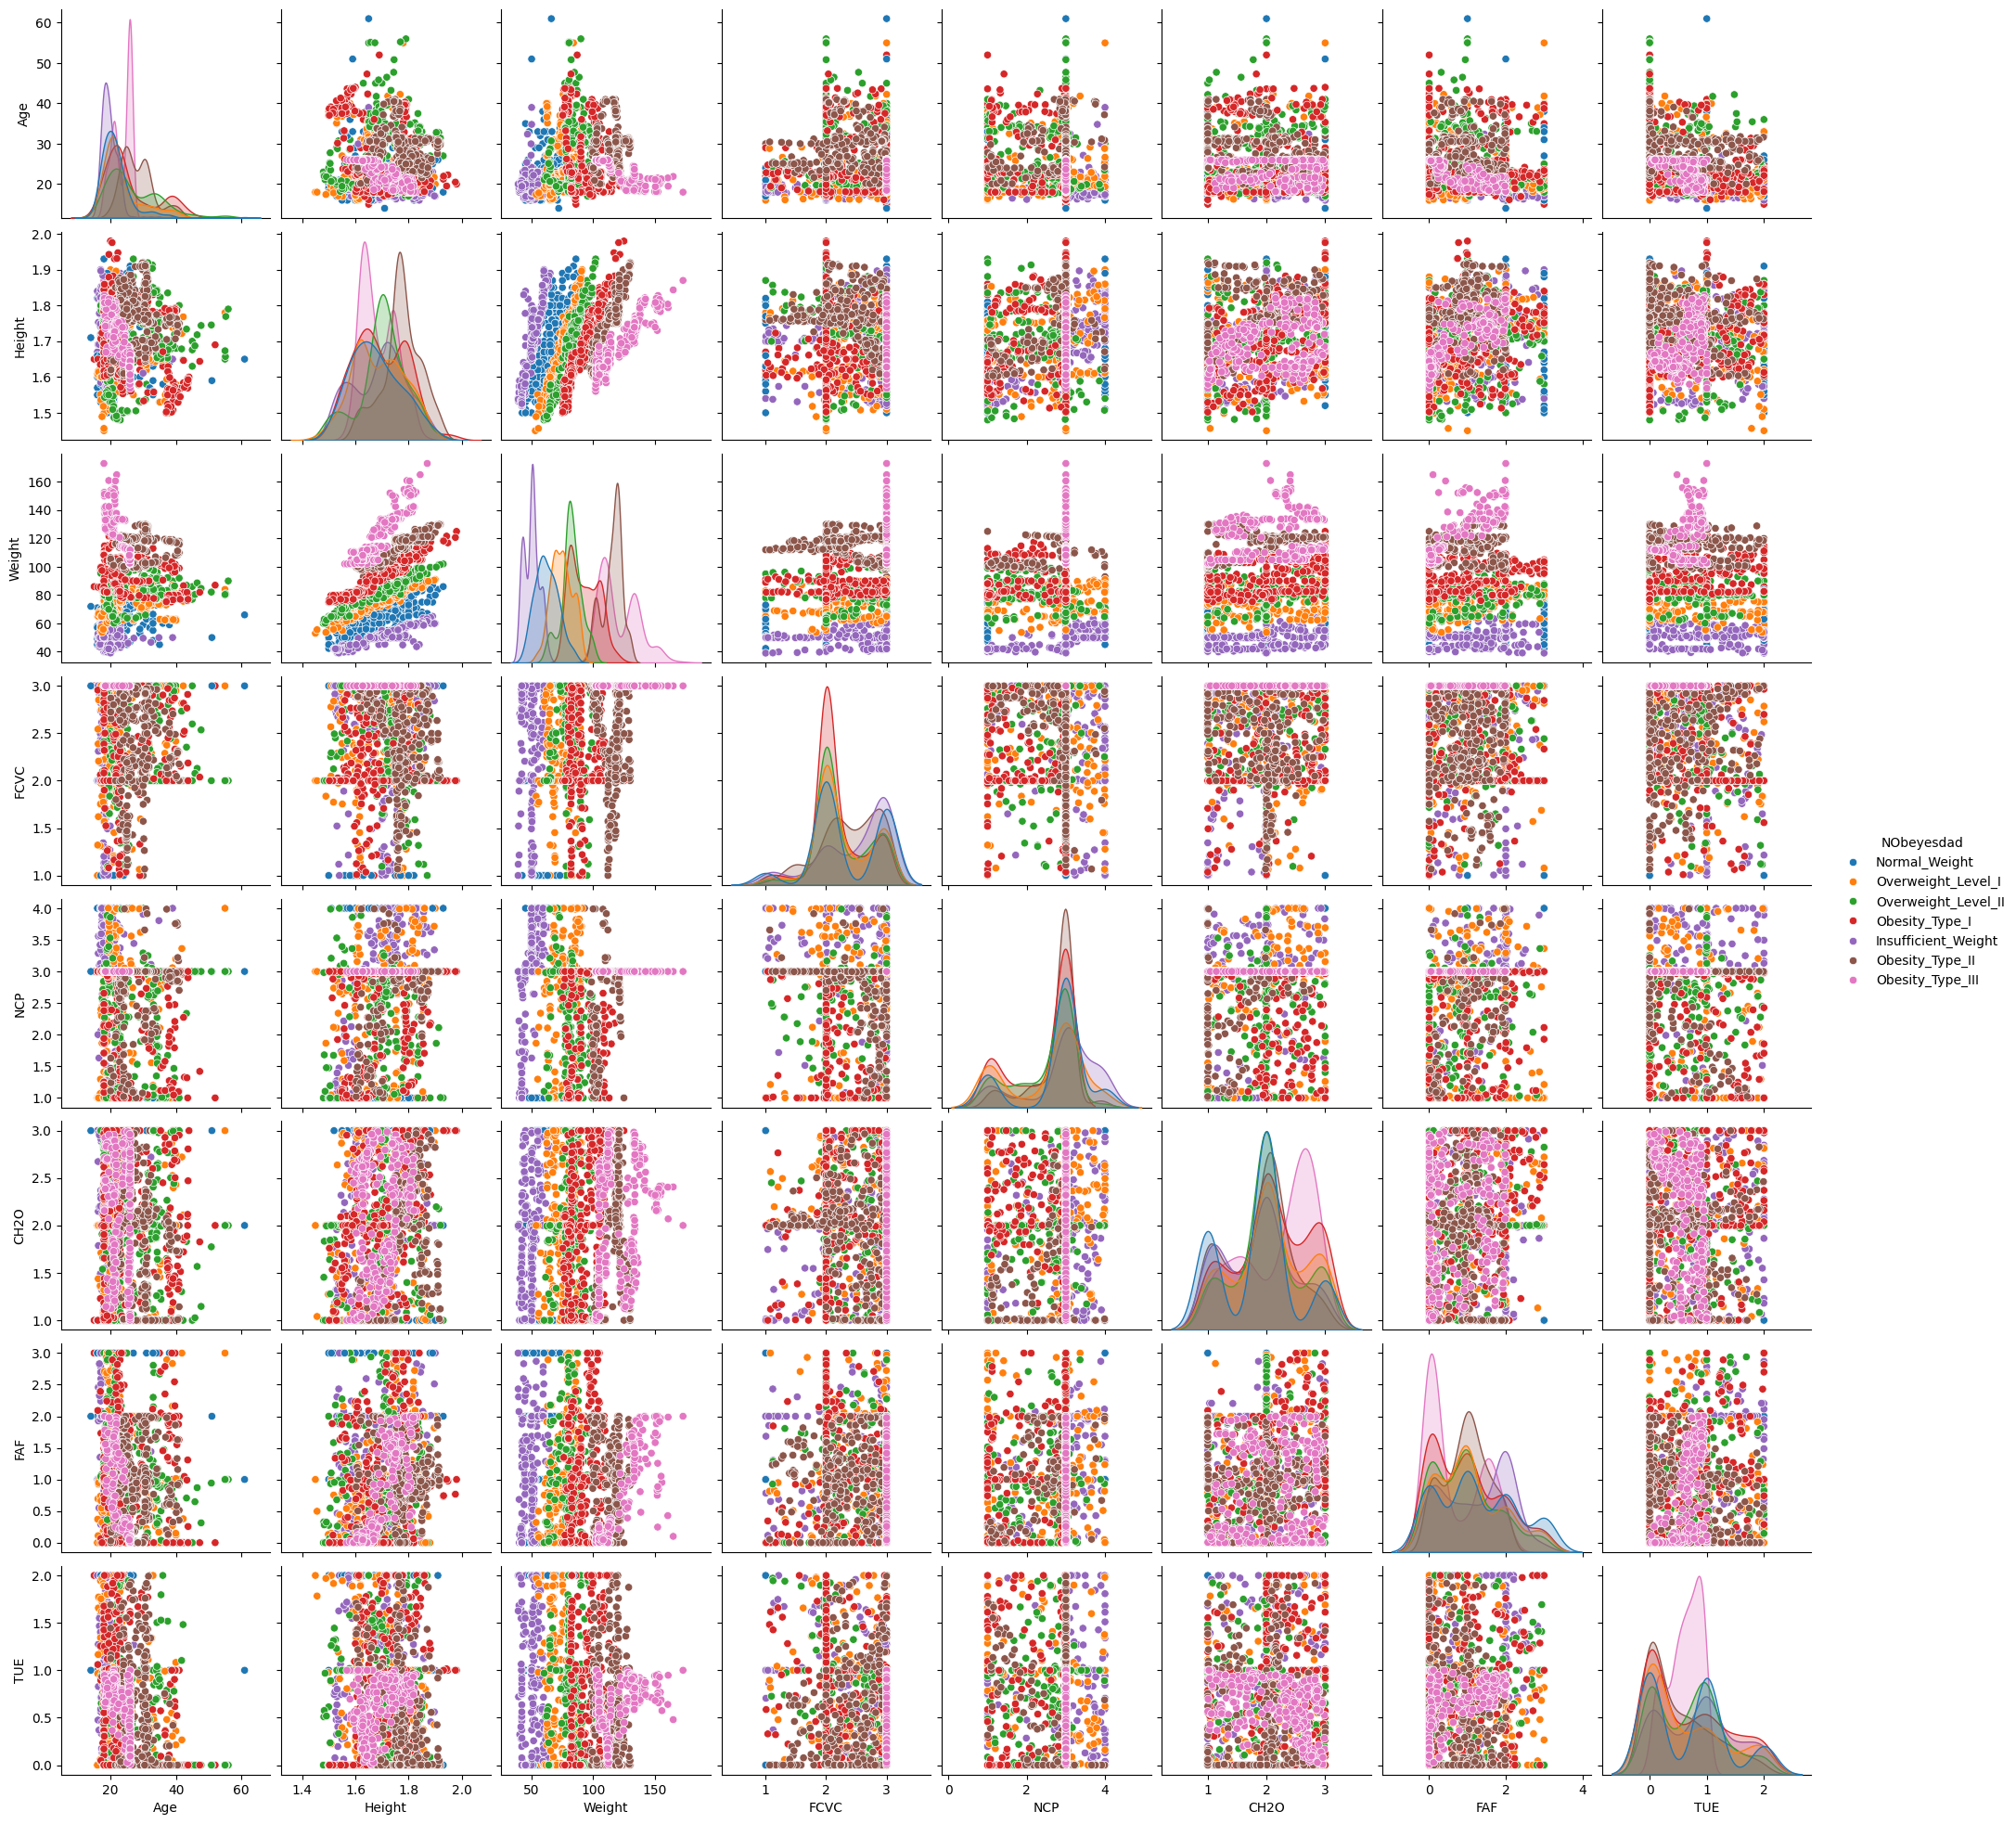

In [17]:
sns.pairplot(source, hue = target_col, vars = numeric_cols)
plt.show()

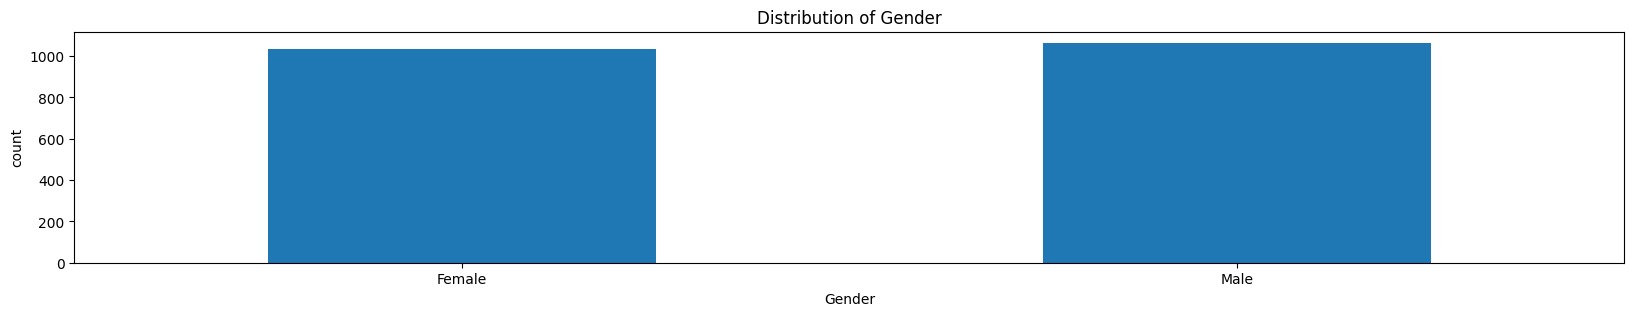

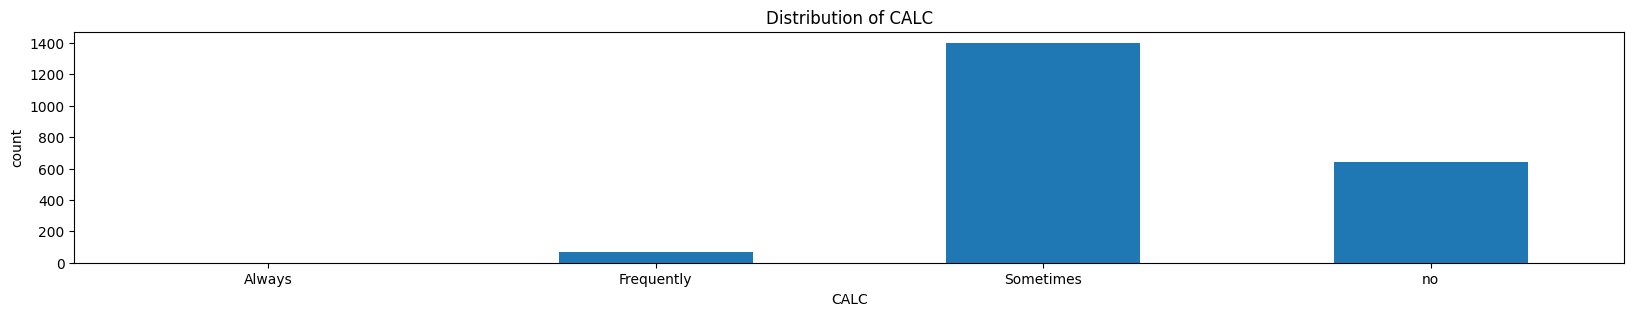

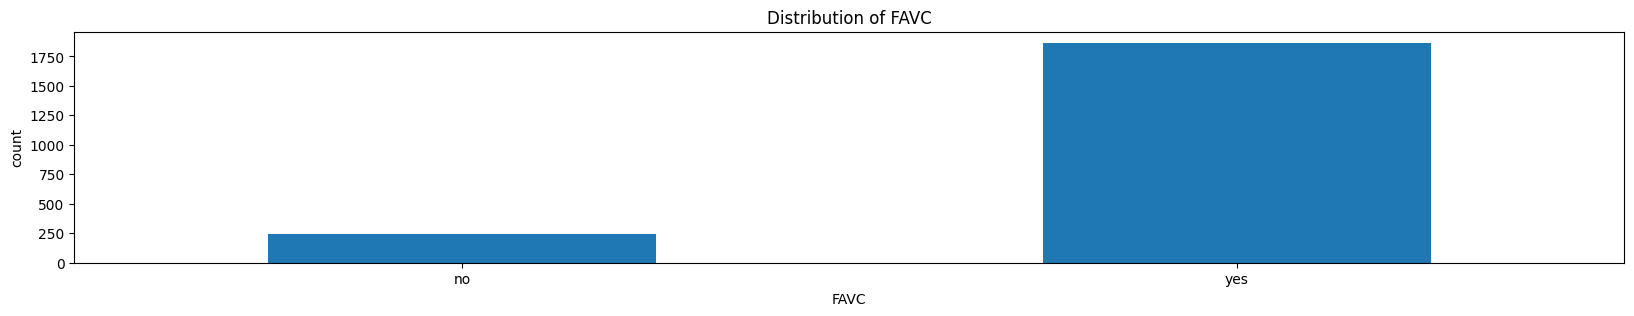

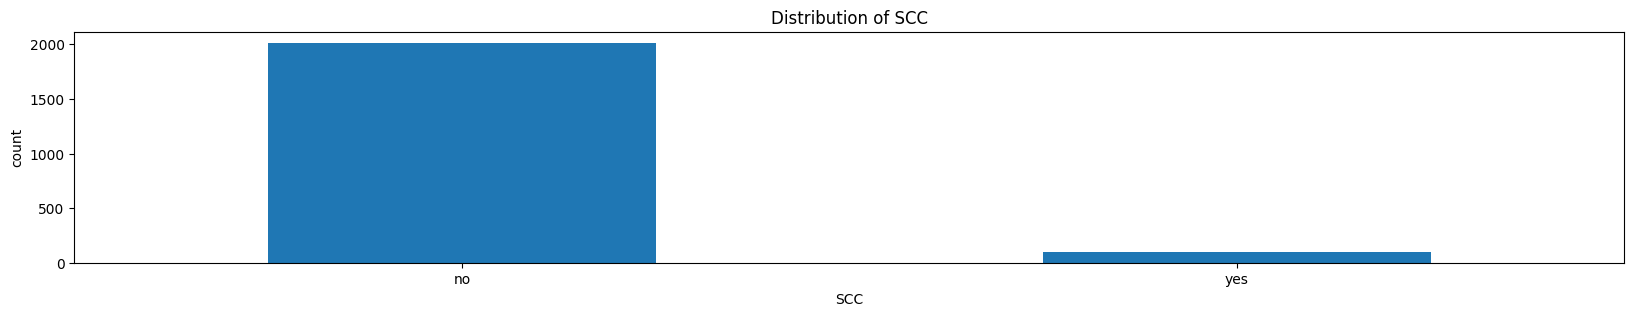

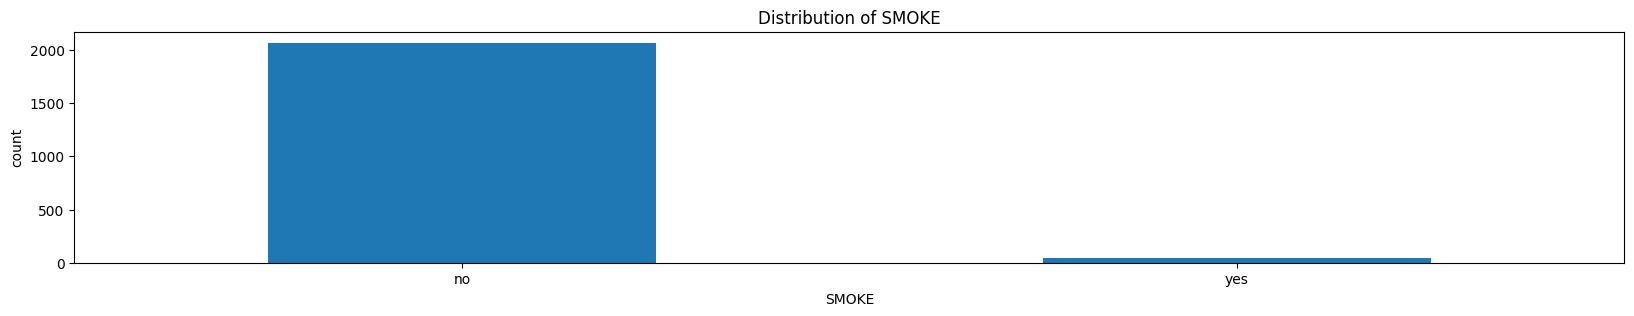

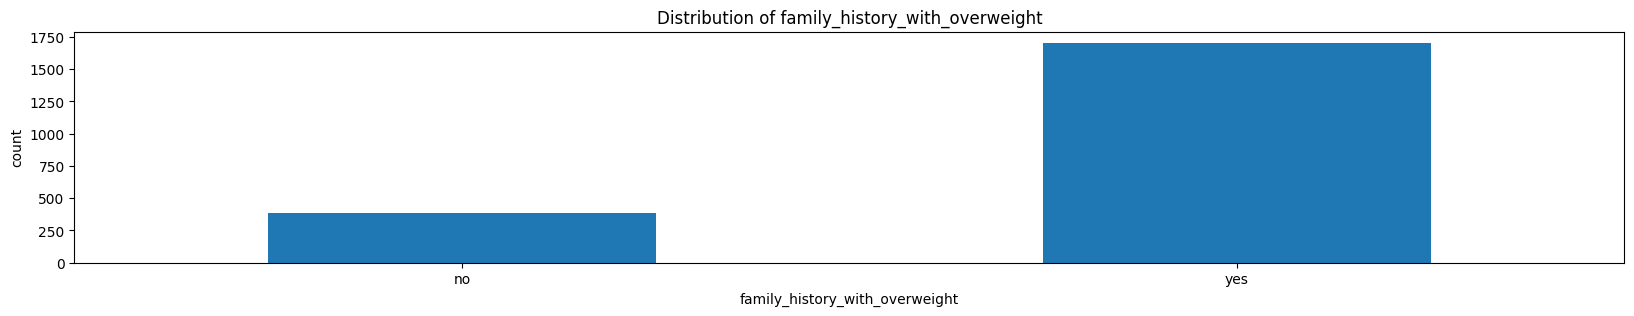

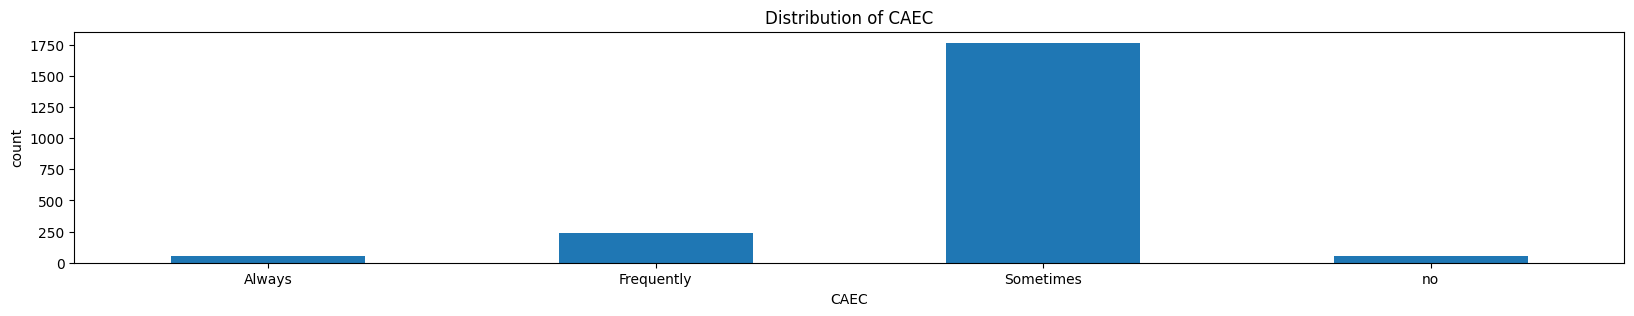

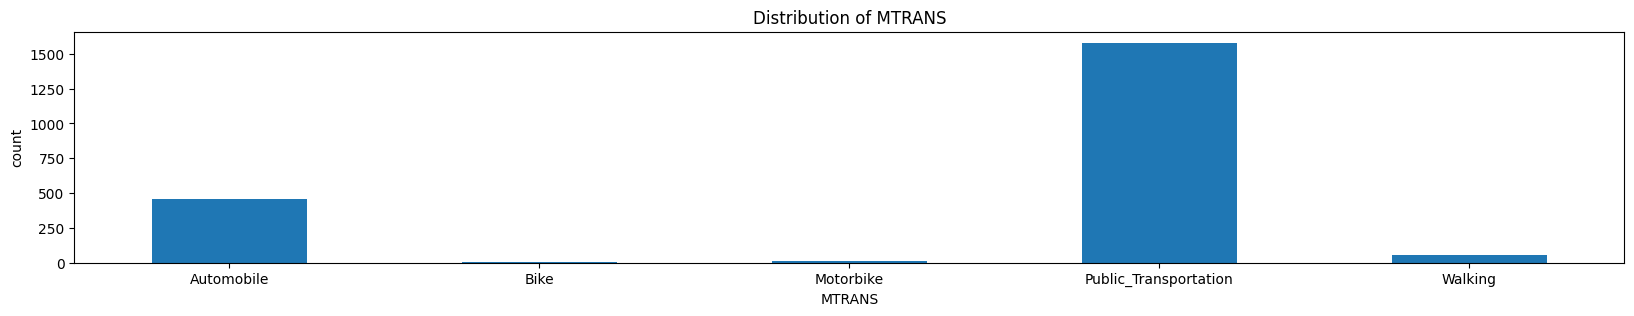

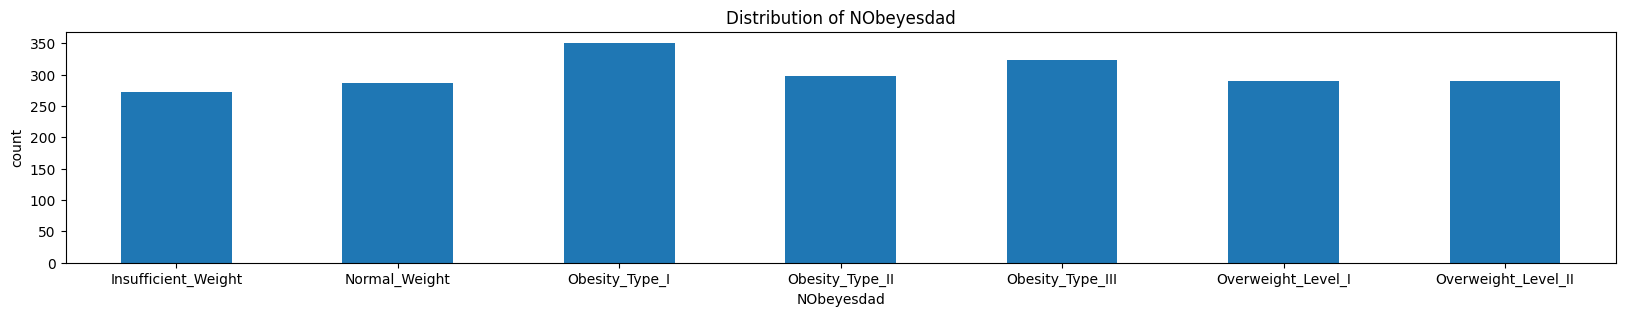

In [18]:
for col in categorical_features:

    plt.figure(figsize = (20, 3))
    source[col].value_counts().sort_index().plot(kind = 'bar', rot = 0, xlabel = col, ylabel='count')
    plt.title(f'Distribution of {col}')
    plt.show()

# **Preprocessing**

***Categorical features handling as found from the above section***

In [19]:

source["Gender"] = source["Gender"].map({"Male" : 0, "Female" : 1})
source["CALC"] = source["CALC"].map({"no" : 0, "Always" : 1, "Sometimes": 0.25, "Frequently": 0.75})
source["FAVC"] = source["FAVC"].map({"no" : 0, "yes" : 1})
source["SCC"] = source["SCC"].map({"no" : 0, "yes" : 1})
source["SMOKE"] = source["SMOKE"].map({"no" : 0, "yes" : 1})
source["family_history_with_overweight"] = source["family_history_with_overweight"].map({"yes": 1, "no": 0})
source["CAEC"] = source["CAEC"].map({"no" : 0, "Always" : 1, "Sometimes": 0.25, "Frequently": 0.75})
source["NObeyesdad"] = source["NObeyesdad"].map({"Normal_Weight" : 1, "Insufficient_Weight": 0, 
                                                 "Overweight_Level_I" : 2, "Overweight_Level_II": 3,
                                                 "Obesity_Type_I": 4, "Obesity_Type_II": 5,
                                                 "Obesity_Type_III": 6})
source.head()

Age  Gender  Height  Weight  CALC  FAVC  FCVC  NCP  SCC  SMOKE  CH2O  \
0  21.0     1.0    1.62    64.0  0.00     0   2.0  3.0    0      0   2.0   
1  21.0     1.0    1.52    56.0  0.25     0   3.0  3.0    1      1   3.0   
2  23.0     0.0    1.80    77.0  0.75     0   2.0  3.0    0      0   2.0   
3  27.0     0.0    1.80    87.0  0.75     0   3.0  3.0    0      0   2.0   
4  22.0     0.0    1.78    89.8  0.25     0   2.0  1.0    0      0   2.0   

   family_history_with_overweight  FAF  TUE  CAEC                 MTRANS  \
0                             1.0  0.0  1.0  0.25  Public_Transportation   
1                             1.0  3.0  0.0  0.25  Public_Transportation   
2                             1.0  2.0  1.0  0.25  Public_Transportation   
3                             0.0  2.0  0.0  0.25                Walking   
4                             0.0  0.0  0.0  0.25  Public_Transportation   

   NObeyesdad  
0           1  
1           1  
2           1  
3           2  
4           3

In [20]:
category_enc = pd.get_dummies(source['MTRANS'])
category_enc.head()
source = pd.concat([source.drop('MTRANS', axis=1), category_enc], axis=1)
features = ["Automobile", "Bike", "Motorbike", "Public_Transportation", "Walking"]
for feature in features:
    source[feature] = source[feature].map({False: 0, True: 1})

source

Age  Gender    Height      Weight  CALC  FAVC  FCVC  NCP  SCC  \
0     21.000000     1.0  1.620000   64.000000  0.00     0   2.0  3.0    0   
1     21.000000     1.0  1.520000   56.000000  0.25     0   3.0  3.0    1   
2     23.000000     0.0  1.800000   77.000000  0.75     0   2.0  3.0    0   
3     27.000000     0.0  1.800000   87.000000  0.75     0   3.0  3.0    0   
4     22.000000     0.0  1.780000   89.800000  0.25     0   2.0  1.0    0   
...         ...     ...       ...         ...   ...   ...   ...  ...  ...   
2106  20.976842     1.0  1.710730  131.408528  0.25     1   3.0  3.0    0   
2107  21.982942     1.0  1.748584  133.742943  0.25     1   3.0  3.0    0   
2108  22.524036     1.0  1.752206  133.689352  0.25     1   3.0  3.0    0   
2109  24.361936     1.0  1.739450  133.346641  0.25     1   3.0  3.0    0   
2110  23.664709     1.0  1.738836  133.472641  0.25     1   3.0  3.0    0   

      SMOKE  ...  family_history_with_overweight       FAF       TUE  CAEC  \
0         0  ...                             1.0  0.000000  1.000000  0.25   
1         1  ...                             1.0  3.000000  0.000000  0.25   
2         0  ...                             1.0  2.000000  1.000000  0.25   
3         0  ...                             0.0  2.000000  0.000000  0.25   
4         0  ...                             0.0  0.000000  0.000000  0.25   
...     ...  ...                             ...       ...       ...   ...   
2106      0  ...                             1.0  1.676269  0.906247  0.25   
2107      0  ...                             1.0  1.341390  0.599270  0.25   
2108      0  ...                             1.0  1.414209  0.646288  0.25   
2109      0  ...                             1.0  1.139107  0.586035  0.25   
2110      0  ...                             1.0  1.026452  0.714137  0.25   

      NObeyesdad  Automobile  Bike  Motorbike  Public_Transportation  Walking  
0              1           0     0          0                      1        0  
1              1           0     0          0                      1        0  
2              1           0     0          0                      1        0  
3              2           0     0          0                      0        1  
4              3           0     0          0                      1        0  
...          ...         ...   ...        ...                    ...      ...  
2106           6           0     0          0                      1        0  
2107           6           0     0          0                      1        0  
2108           6           0     0          0                      1        0  
2109           6           0     0          0                      1        0  
2110           6           0     0          0                      1        0  

[2111 rows x 21 columns]

***NULL Handling***

In [21]:
source.head(4)

Age  Gender  Height  Weight  CALC  FAVC  FCVC  NCP  SCC  SMOKE  ...  \
0  21.0     1.0    1.62    64.0  0.00     0   2.0  3.0    0      0  ...   
1  21.0     1.0    1.52    56.0  0.25     0   3.0  3.0    1      1  ...   
2  23.0     0.0    1.80    77.0  0.75     0   2.0  3.0    0      0  ...   
3  27.0     0.0    1.80    87.0  0.75     0   3.0  3.0    0      0  ...   

   family_history_with_overweight  FAF  TUE  CAEC  NObeyesdad  Automobile  \
0                             1.0  0.0  1.0  0.25           1           0   
1                             1.0  3.0  0.0  0.25           1           0   
2                             1.0  2.0  1.0  0.25           1           0   
3                             0.0  2.0  0.0  0.25           2           0   

   Bike  Motorbike  Public_Transportation  Walking  
0     0          0                      1        0  
1     0          0                      1        0  
2     0          0                      1        0  
3     0          0                      0        1  

[4 rows x 21 columns]

In [22]:
print(source.shape)
print(source.isnull().sum())

(2111, 21)
Age                                0
Gender                            11
Height                             0
Weight                             0
CALC                               0
FAVC                               0
FCVC                               0
NCP                                0
SCC                                0
SMOKE                              0
CH2O                              21
family_history_with_overweight    21
FAF                                0
TUE                                0
CAEC                               0
NObeyesdad                         0
Automobile                         0
Bike                               0
Motorbike                          0
Public_Transportation              0
Walking                            0
dtype: int64


In [23]:
row_nulls = source.isnull().sum(axis = 1)
rows_with_nulls = row_nulls[row_nulls > 0]
for idx, count in rows_with_nulls.items():
    print(f"Row {idx} → {count} null(s)")

Row 48 → 1 null(s)
Row 70 → 1 null(s)
Row 71 → 1 null(s)
Row 125 → 1 null(s)
Row 143 → 1 null(s)
Row 157 → 1 null(s)
Row 196 → 1 null(s)
Row 205 → 1 null(s)
Row 263 → 1 null(s)
Row 274 → 1 null(s)
Row 281 → 1 null(s)
Row 284 → 1 null(s)
Row 314 → 1 null(s)
Row 324 → 1 null(s)
Row 330 → 1 null(s)
Row 420 → 1 null(s)
Row 463 → 1 null(s)
Row 501 → 1 null(s)
Row 527 → 1 null(s)
Row 544 → 1 null(s)
Row 603 → 1 null(s)
Row 634 → 1 null(s)
Row 722 → 1 null(s)
Row 730 → 1 null(s)
Row 744 → 1 null(s)
Row 792 → 1 null(s)
Row 932 → 1 null(s)
Row 965 → 1 null(s)
Row 995 → 1 null(s)
Row 1040 → 1 null(s)
Row 1178 → 1 null(s)
Row 1241 → 1 null(s)
Row 1257 → 1 null(s)
Row 1411 → 1 null(s)
Row 1442 → 1 null(s)
Row 1444 → 1 null(s)
Row 1449 → 1 null(s)
Row 1450 → 1 null(s)
Row 1454 → 1 null(s)
Row 1483 → 1 null(s)
Row 1561 → 1 null(s)
Row 1563 → 1 null(s)
Row 1582 → 1 null(s)
Row 1635 → 1 null(s)
Row 1656 → 1 null(s)
Row 1673 → 1 null(s)
Row 1812 → 1 null(s)
Row 1831 → 1 null(s)
Row 1916 → 1 null(s)
Row

No row/column had to be dropped ^

***NULL Transform***

In [24]:
print(source.isnull().sum())

Age                                0
Gender                            11
Height                             0
Weight                             0
CALC                               0
FAVC                               0
FCVC                               0
NCP                                0
SCC                                0
SMOKE                              0
CH2O                              21
family_history_with_overweight    21
FAF                                0
TUE                                0
CAEC                               0
NObeyesdad                         0
Automobile                         0
Bike                               0
Motorbike                          0
Public_Transportation              0
Walking                            0
dtype: int64


In [25]:
median_imputer = SimpleImputer(strategy = "median")
mode_imputer = SimpleImputer(strategy = "most_frequent")

source[["CH2O"]] = median_imputer.fit_transform(source[["CH2O"]])
source[["Gender", "family_history_with_overweight"]] = mode_imputer.fit_transform(source[["Gender", "family_history_with_overweight"]])

In [26]:
print(source.isnull().sum())

Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
NObeyesdad                        0
Automobile                        0
Bike                              0
Motorbike                         0
Public_Transportation             0
Walking                           0
dtype: int64


Took Median value for NULL values in CH2O column and Mode value for NULL values in Gender and family_history_with_overweight colms ^

No Column has to be dropped as all the columns are relevant to the target

***Finding feature - feature correlation using heatmap (to be used in question 6 of dataset description)***

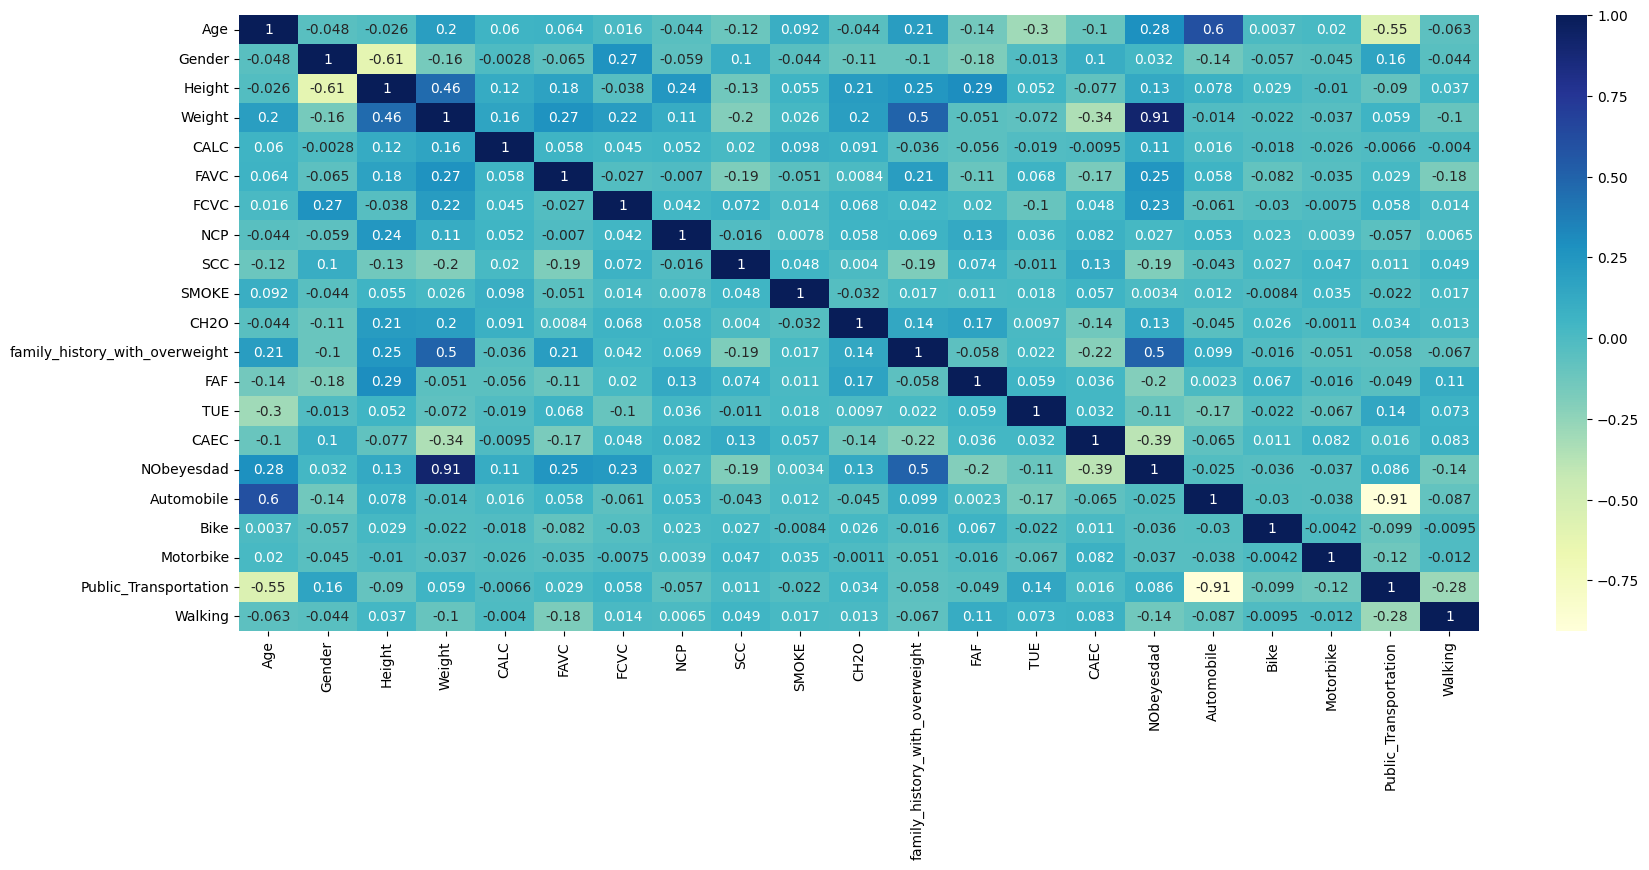

In [27]:
correlation_plot(source)

No notable feature - feature correlation ^

***Export for Split before Normalization***

In [28]:
source.to_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/processed_dataset.csv", index = False)
source = pd.read_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/processed_dataset.csv")
split_dataset(source)

Train set size: (1477, 20)
Test set size: (634, 20)


# **Normalization**

In [29]:
X_train = pd.read_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/X_train.csv")
X_test = pd.read_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/X_test.csv")
y_train = pd.read_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/y_train.csv")
y_test = pd.read_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/y_test.csv")

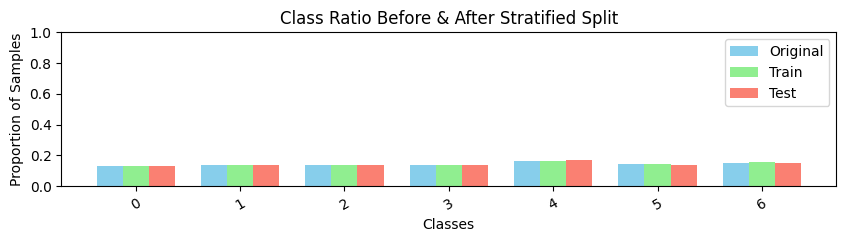

In [30]:
# Original target
y_original = source['NObeyesdad']

if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train_labels = y_train.argmax(axis=1)
    y_test_labels  = y_test.argmax(axis=1)
else:
    y_train_labels = y_train.values.ravel()  # or .flatten()
    y_test_labels  = y_test.values.ravel()



original_props = y_original.value_counts(normalize=True).sort_index()
train_props    = pd.Series(y_train_labels).value_counts(normalize=True).sort_index()
test_props     = pd.Series(y_test_labels).value_counts(normalize=True).sort_index()

# Plot
classes = original_props.index
x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10,2))
plt.bar(x - width, original_props.values, width, label="Original", color="skyblue")
plt.bar(x, train_props.values, width, label="Train", color="lightgreen")
plt.bar(x + width, test_props.values, width, label="Test", color="salmon")

plt.xlabel("Classes")
plt.ylabel("Proportion of Samples")
plt.title("Class Ratio Before & After Stratified Split")
plt.xticks(x, classes, rotation=30)
plt.ylim(0, 1)
plt.legend()
plt.show()

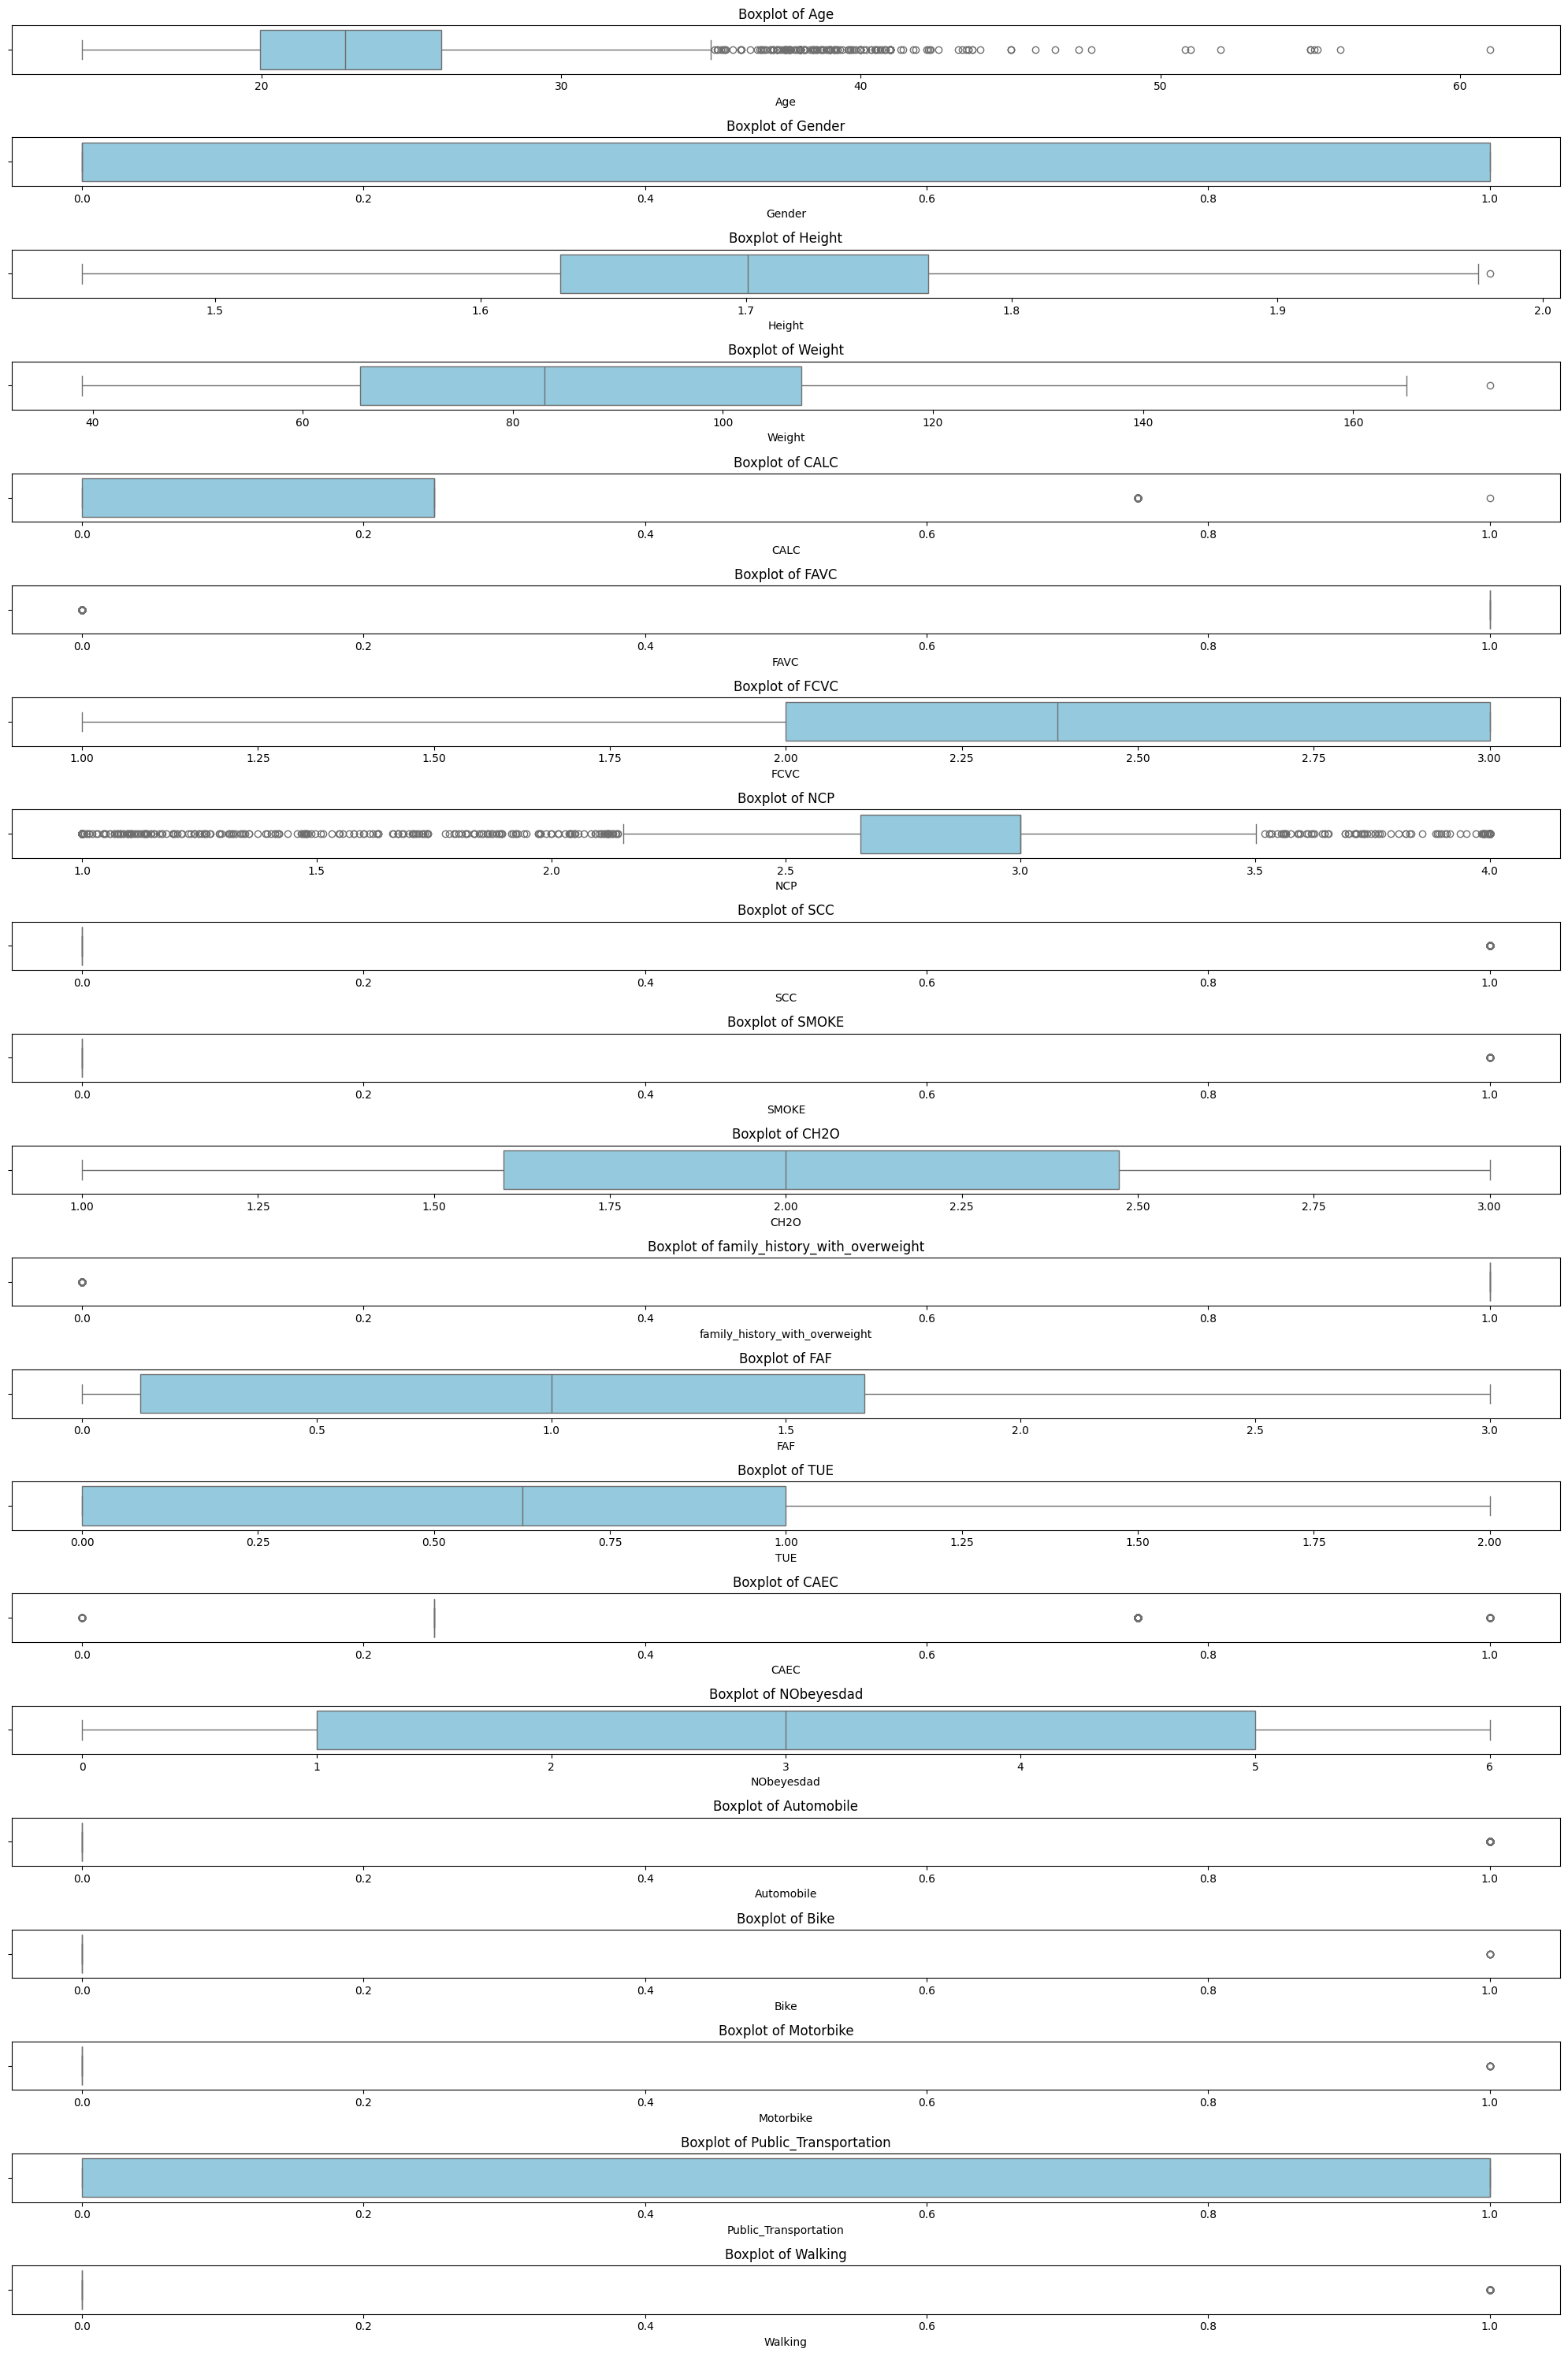

In [31]:
numeric_cols = source.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize = (20, 30))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x = source[col], color = 'skyblue')
    plt.title(f'Boxplot of {col}', fontsize = 12)
    plt.tight_layout()

plt.show()

In [32]:
# Applying Normalization techniques based on the outliers
scaler_mapping = {
    'Age': 'RobustScaler',
    'NCP': 'RobustScaler',
    'Height': 'StandardScaler',
    'Weight': 'StandardScaler',
    'CALC': 'RobustScaler',
    'FCVC': 'StandardScaler',
    'CH2O': 'StandardScaler',
    'FAF': 'StandardScaler',
    'TUE': 'StandardScaler',
    'CAEC': 'RobustScaler',
}

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

for feature, scaler_type in scaler_mapping.items():
    if scaler_type == 'MinMaxScaler':
        X_train_scaled, X_test_scaled = scale_minmax(X_train_scaled, X_test_scaled, [feature])
    elif scaler_type == 'StandardScaler':
        X_train_scaled, X_test_scaled = scale_standard(X_train_scaled, X_test_scaled, [feature])
    elif scaler_type == 'RobustScaler':
        X_train_scaled, X_test_scaled = scale_robust(X_train_scaled, X_test_scaled, [feature])

X_scaled_combined = pd.concat([X_train_scaled, X_test_scaled], axis = 0).reset_index(drop = True)
y_combined = pd.concat([y_train, y_test], axis = 0).reset_index(drop = True)

preprocessed_dataset_scaled = X_scaled_combined.copy()
preprocessed_dataset_scaled['target'] = y_combined 
preprocessed_dataset_scaled

Age  Gender    Height    Weight  CALC  FAVC      FCVC       NCP  \
0     0.187931     0.0 -0.923914  0.539578  -1.0     1  0.872726 -3.466577   
1    -0.222125     1.0  1.112428  2.871914   0.0     1  1.098762  0.000000   
2     2.775739     0.0  0.965450  0.453708   0.0     1 -0.710481 -2.113806   
3     1.012959     0.0  2.244734  1.683830   0.0     1 -0.402662  0.000000   
4    -0.308298     0.0 -0.860279 -0.628454   0.0     1 -0.792484 -5.346764   
...        ...     ...       ...       ...   ...   ...       ...       ...   
2106  0.518231     1.0 -0.736263  0.977641   0.0     1  1.098762  0.000000   
2107  0.518231     1.0 -0.738572  0.986961   0.0     1  1.098762  0.000000   
2108  0.000446     1.0 -0.479940 -1.384426  -1.0     1  1.098762  1.718455   
2109 -0.804216     0.0  0.887369  0.840765  -1.0     1 -0.792484 -0.921608   
2110  0.002899     0.0  1.002600  0.140414   0.0     1 -0.983280 -1.670794   

      SCC  SMOKE  ...  family_history_with_overweight       FAF       TUE  \
0       0      0  ...                             1.0  0.087554  0.681499   
1       0      0  ...                             1.0 -0.677285 -0.006556   
2       0      0  ...                             1.0  0.303139  0.042355   
3       0      0  ...                             1.0  0.130509 -1.059578   
4       0      0  ...                             0.0 -0.002895 -1.059578   
...   ...    ...  ...                             ...       ...       ...   
2106    0      0  ...                             1.0 -1.181703 -0.643837   
2107    0      0  ...                             1.0 -1.181703 -0.669061   
2108    0      0  ...                             1.0 -1.042284 -0.951765   
2109    0      0  ...                             1.0 -0.002895 -0.150102   
2110    0      0  ...                             1.0 -1.181703  1.187998   

      CAEC  Automobile  Bike  Motorbike  Public_Transportation  Walking  \
0     0.00           0     0          0                      1        0   
1     0.00           0     0          0                      1        0   
2     0.00           1     0          0                      0        0   
3     0.00           0     0          0                      1        0   
4    -0.25           0     0          0                      1        0   
...    ...         ...   ...        ...                    ...      ...   
2106  0.00           0     0          0                      1        0   
2107  0.00           0     0          0                      1        0   
2108  0.50           0     0          0                      1        0   
2109  0.00           0     0          0                      1        0   
2110  0.00           0     0          0                      1        0   

      target  
0          5  
1          6  
2          4  
3          5  
4          2  
...      ...  
2106       6  
2107       6  
2108       0  
2109       4  
2110       3  

[2111 rows x 21 columns]

In [33]:
X_train_scaled.to_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/X_train_scaled.csv", index = False)
X_test_scaled.to_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/X_test_scaled.csv", index = False)
preprocessed_dataset_scaled.to_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/scaled_processed_dataset.csv", index = False)

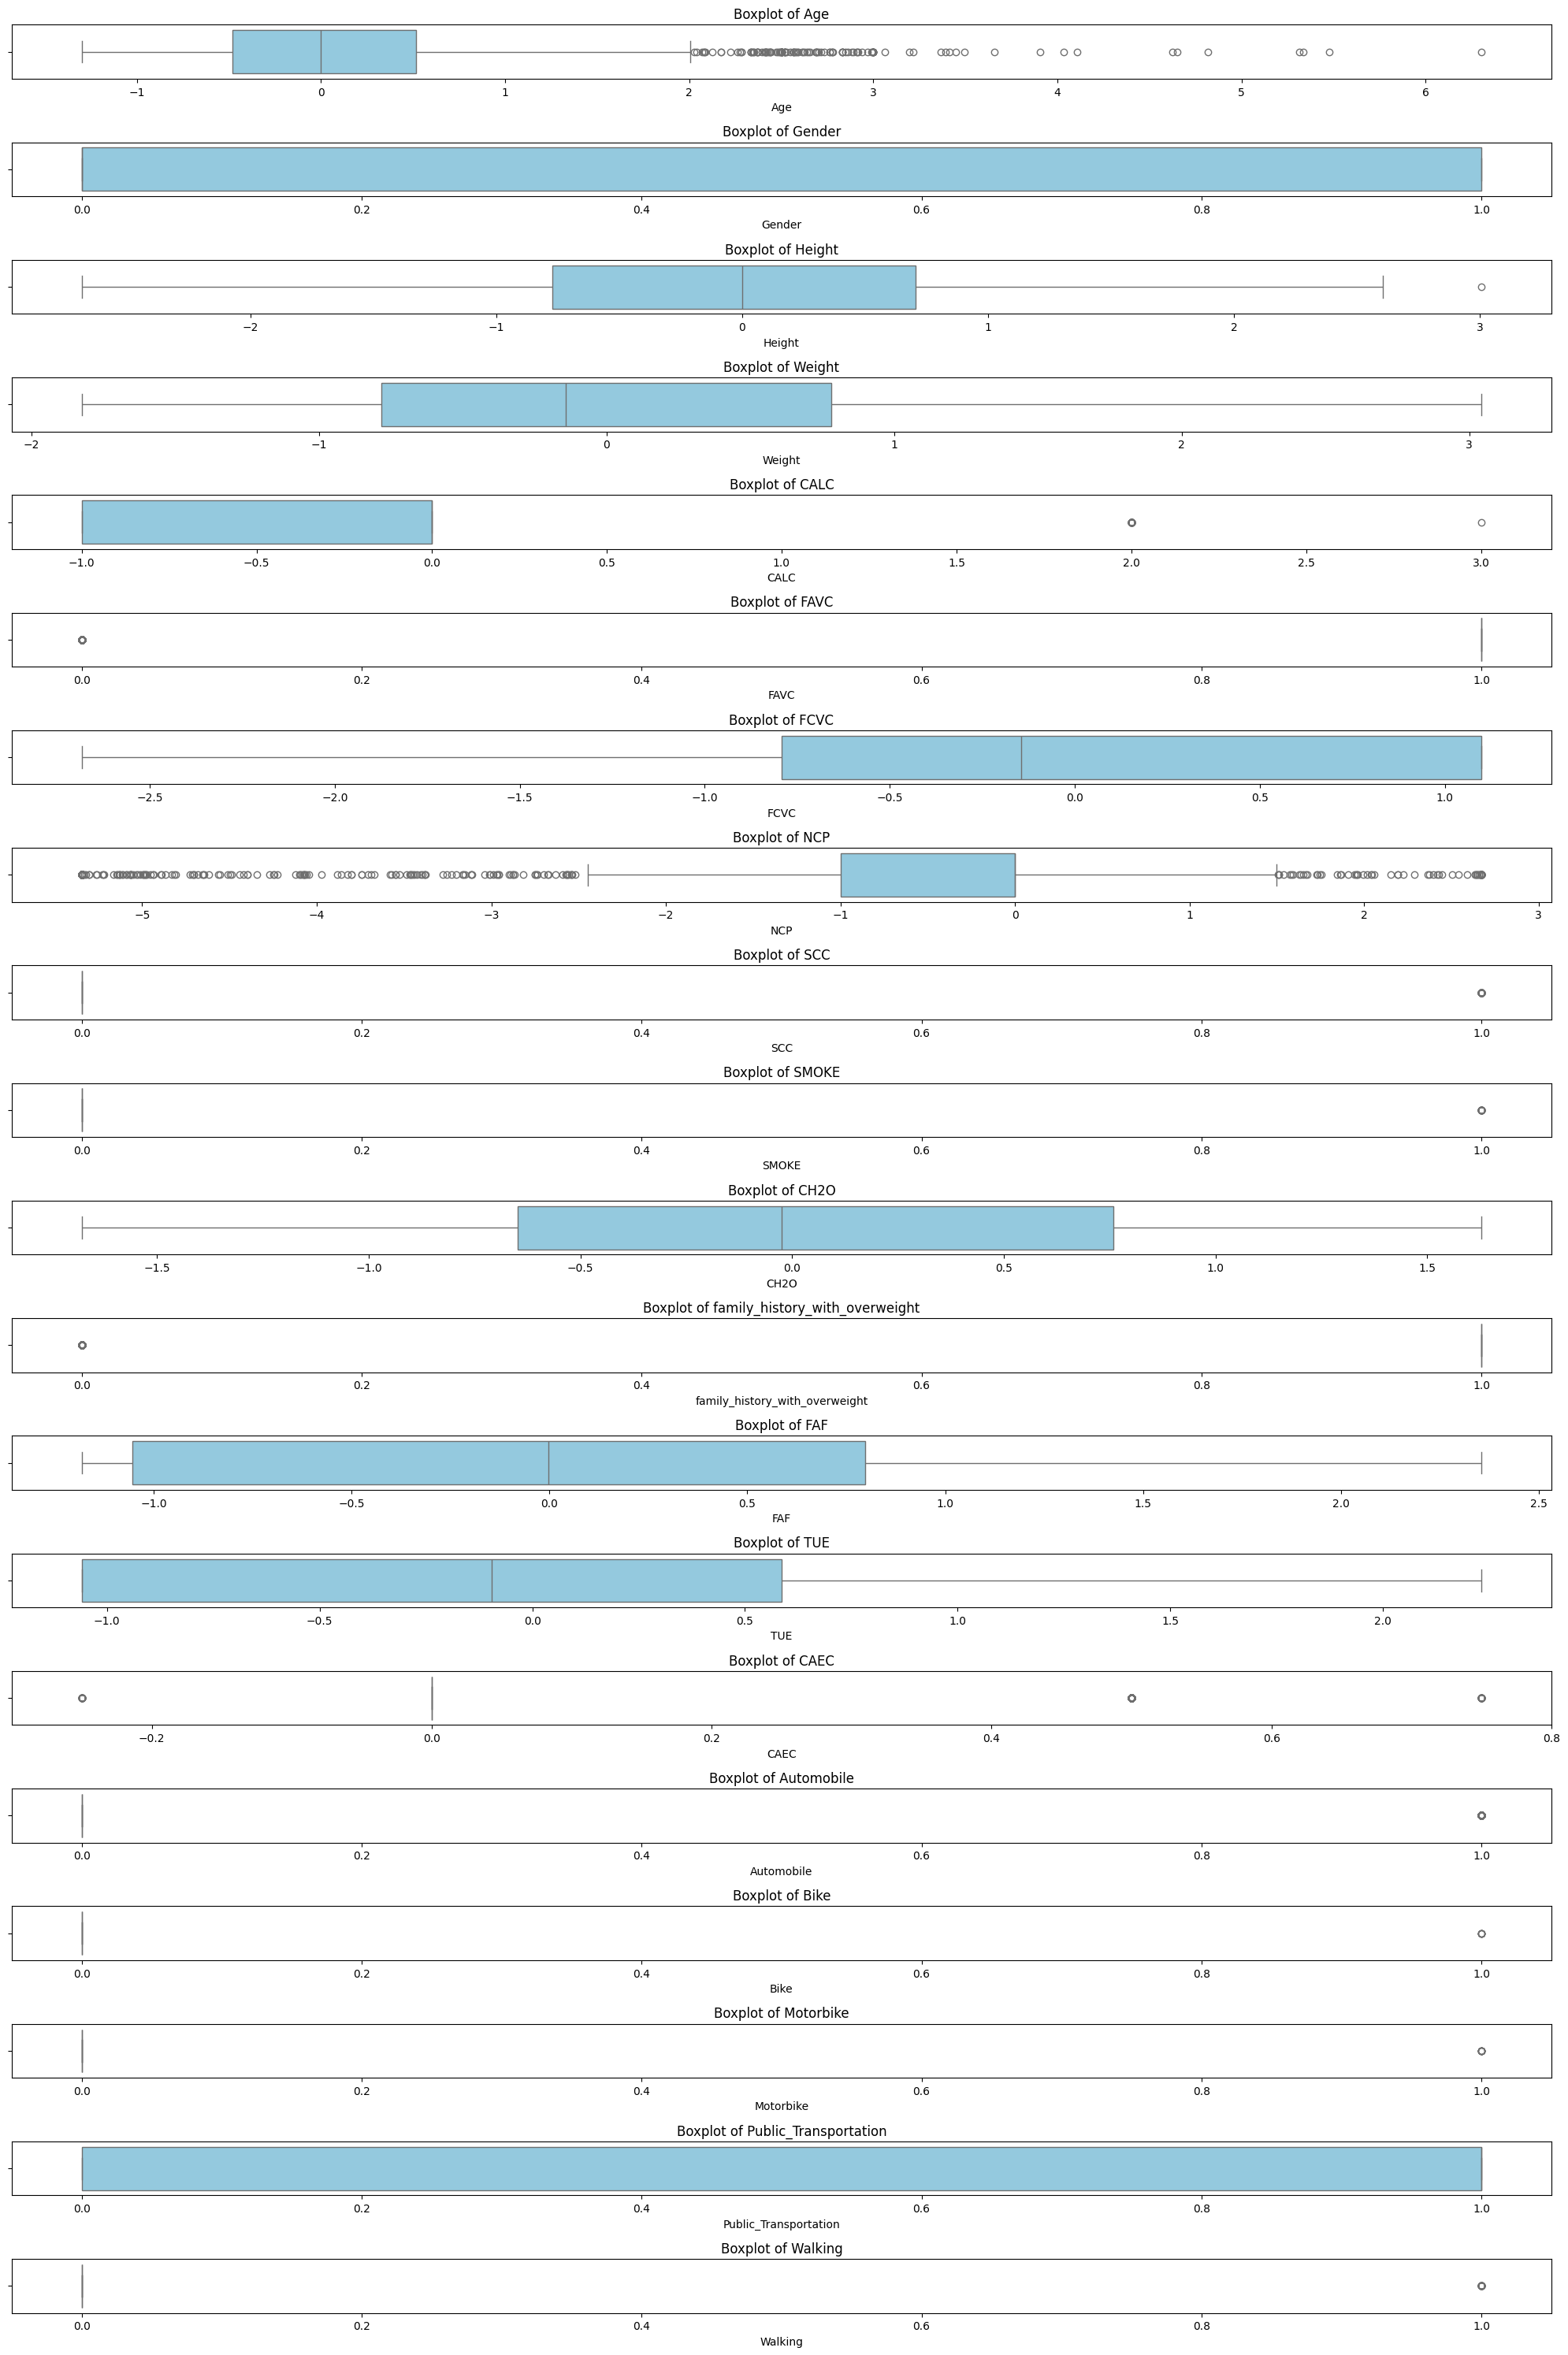

In [34]:
numeric_cols = X_train_scaled.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize = (20, 30))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x = X_train_scaled[col], color = 'skyblue')
    plt.title(f'Boxplot of {col}', fontsize = 12)
    plt.tight_layout()

plt.show()


In [35]:
X_train_scaled = pd.read_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/X_train_scaled.csv")
X_test_scaled = pd.read_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/X_test_scaled.csv")

# **Classical Models**


In [36]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [37]:
knn, knn_pred, accuracy = knn_predict()
print(f"Accuracy of the model for the value of K mentioned above: {(accuracy * 100):.2f}%")

Best value of K is 1
Accuracy of the model for the value of K mentioned above: 86.12%


In [38]:
log, log_pred, accuracy = log_predict()
print(f"Logistic Regression prediction accuracy: {(accuracy * 100):.2f}")

Logistic Regression prediction accuracy: 88.01


In [39]:
nb, nb_pred, accuracy = nb_predict()
print(f"Naive Bayes Prediction accuracy {(accuracy * 100):.2f}%")

Naive Bayes Prediction accuracy 54.42%


In [40]:
dt, dt_pred, accuracy = dt_predict()
print(f"Decision Tree prediction accuracy: {(accuracy * 100):.2f}")

Decision Tree prediction accuracy: 94.01


# **Neural Network**

In [41]:
num_features = X_train_scaled.shape[1]
num_classes  = np.unique(y_train).size

In [42]:
nn = Sequential([
    layers.Input(shape = (num_features,)),

    #layers.Dense(512, activation = 'relu'),
    #layers.BatchNormalization(),
    #layers.Dropout(0.3),
    
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation = 'relu'),
    layers.Dense(num_classes, activation = 'softmax')  # multiclass output
])

In [43]:
nn.compile(
    optimizer = optimizers.Adam(learning_rate = 1e-3),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [44]:
early_stop = callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 10, restore_best_weights = True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.5, patience = 3
)

In [45]:
history = nn.fit(
    X_train_scaled, y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 180,
    batch_size = 256,
    callbacks = [early_stop, reduce_lr],
)

Epoch 1/180
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1679 - loss: 2.5533 - val_accuracy: 0.1987 - val_loss: 1.9044 - learning_rate: 0.0010
Epoch 2/180
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2769 - loss: 2.0796 - val_accuracy: 0.4306 - val_loss: 1.8430 - learning_rate: 0.0010
Epoch 3/180
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3866 - loss: 1.7070 - val_accuracy: 0.5158 - val_loss: 1.7826 - learning_rate: 0.0010
Epoch 4/180
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4577 - loss: 1.5401 - val_accuracy: 0.5394 - val_loss: 1.7231 - learning_rate: 0.0010
Epoch 5/180
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5112 - loss: 1.3623 - val_accuracy: 0.5237 - val_loss: 1.6668 - learning_rate: 0.0010
Epoch 6/180
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5545 - loss: 1.2504 - val_accuracy: 0.4890 - val_loss: 1.6136 - learning_rate: 0.0010
Epoch 7/180
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5992 - loss: 1.1239 - val_accuracy: 0.495

In [46]:
test_loss, test_acc = nn.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

nn_pred = nn.predict(X_test_scaled)
y_pred_cls = nn_pred.argmax(axis = 1)


Test accuracy: 0.9527
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


# **Kmeans Clustering**

In [47]:
#Treating the target as a feature as well
df = pd.read_csv("/Users/dihanislamdhrubo/Downloads/CSE422-Lab-Project-main/data/scaled_processed_dataset.csv")

In [48]:
sse = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(df)
    sse.append(kmeans.inertia_) # Append the squared distance of each cluster to their centroid

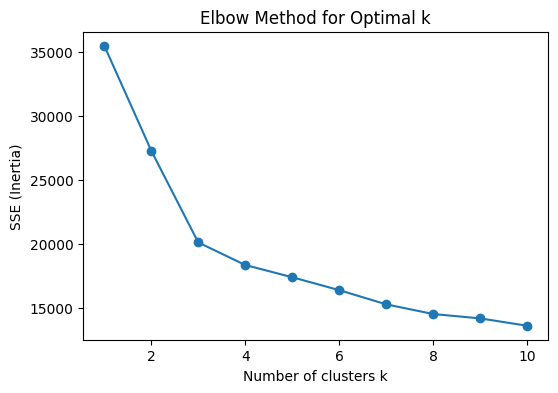

In [49]:
# Finding elbow
plt.figure(figsize = (6 , 4))
plt.plot(K_range, sse, marker = 'o')
plt.xlabel("Number of clusters k")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [50]:
boss_k = 3
kmeans = KMeans(n_clusters = boss_k, random_state = 42)
labels = kmeans.fit_predict(df)

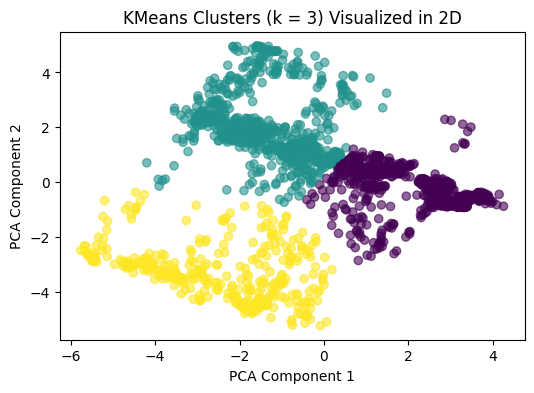

In [51]:
df['cluster'] = labels
pca = PCA(n_components = 2) # Fit all the features into n_components number of axes
X_pca = pca.fit_transform(df)
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[: , 0], X_pca[: , 1], c = labels, cmap = 'viridis', alpha = 0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"KMeans Clusters (k = {boss_k}) Visualized in 2D")
plt.show()

# **Comparison Analysis**

In [52]:
dt_pred = dt.predict(X_test_scaled)

dt_accuracy  = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred, average="macro", zero_division=0)
dt_recall    = recall_score(y_test, dt_pred, average="macro", zero_division=0)
dt_f1        = f1_score(y_test, dt_pred, average="macro", zero_division=0)
dt_cm        = confusion_matrix(y_test, dt_pred)

# ROC / AUC (multi-class)
try:
    dt_prob = dt.predict_proba(X_test_scaled)
    dt_auc = roc_auc_score(y_test, dt_prob, multi_class="ovr")
    dt_fpr, dt_tpr = {}, {}
    for i in range(dt_prob.shape[1]):
        dt_fpr[i], dt_tpr[i], _ = roc_curve(y_test == i, dt_prob[:, i])
except:
    dt_auc = None
    dt_fpr = dt_tpr = None



In [53]:
knn_pred = knn.predict(X_test_scaled)
knn_accuracy  = accuracy_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred, average="macro", zero_division=0)
knn_recall    = recall_score(y_test, knn_pred, average="macro", zero_division=0)
knn_f1        = f1_score(y_test, knn_pred, average="macro", zero_division=0)
knn_cm        = confusion_matrix(y_test, knn_pred)

# ROC / AUC
try:
    knn_prob = knn.predict_proba(X_test_scaled)
    knn_auc = roc_auc_score(y_test, knn_prob, multi_class="ovr")
    knn_fpr, knn_tpr = {}, {}
    for i in range(knn_prob.shape[1]):
        knn_fpr[i], knn_tpr[i], _ = roc_curve(y_test == i, knn_prob[:, i])
except:
    knn_auc = None
    knn_fpr = knn_tpr = None


In [54]:
log_pred = log.predict(X_test_scaled)
log_accuracy  = accuracy_score(y_test, log_pred)
log_precision = precision_score(y_test, log_pred, average="macro", zero_division=0)
log_recall    = recall_score(y_test, log_pred, average="macro", zero_division=0)
log_f1        = f1_score(y_test, log_pred, average="macro", zero_division=0)
log_cm        = confusion_matrix(y_test, log_pred)

log_prob = log.predict_proba(X_test_scaled)
log_auc = roc_auc_score(y_test, log_prob, multi_class="ovr")
log_fpr, log_tpr = {}, {}
for i in range(log_prob.shape[1]):
    log_fpr[i], log_tpr[i], _ = roc_curve(y_test == i, log_prob[:, i])


In [55]:
nb_pred = nb.predict(X_test_scaled)
nb_accuracy  = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred, average="macro", zero_division=0)
nb_recall    = recall_score(y_test, nb_pred, average="macro", zero_division=0)
nb_f1        = f1_score(y_test, nb_pred, average="macro", zero_division=0)
nb_cm        = confusion_matrix(y_test, nb_pred)

nb_prob = nb.predict_proba(X_test_scaled)
nb_auc = roc_auc_score(y_test, nb_prob, multi_class="ovr")
nb_fpr, nb_tpr = {}, {}
for i in range(nb_prob.shape[1]):
    nb_fpr[i], nb_tpr[i], _ = roc_curve(y_test == i, nb_prob[:, i])


In [56]:
nn_pred_prob = nn.predict(X_test_scaled)
nn_pred = np.argmax(nn_pred_prob, axis=1)

nn_accuracy  = accuracy_score(y_test, nn_pred)
nn_precision = precision_score(y_test, nn_pred, average="macro", zero_division=0)
nn_recall    = recall_score(y_test, nn_pred, average="macro", zero_division=0)
nn_f1        = f1_score(y_test, nn_pred, average="macro", zero_division=0)
nn_cm        = confusion_matrix(y_test, nn_pred)

nn_auc = roc_auc_score(y_test, nn_pred_prob, multi_class="ovr")
nn_fpr, nn_tpr = {}, {}
for i in range(nn_pred_prob.shape[1]):
    nn_fpr[i], nn_tpr[i], _ = roc_curve(y_test == i, nn_pred_prob[:, i])


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


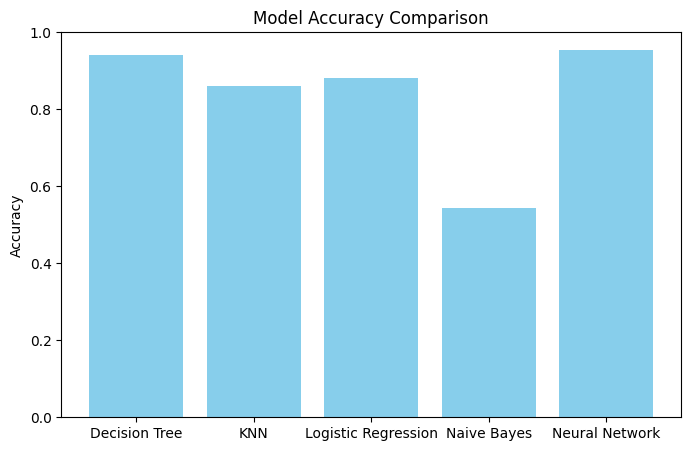

In [57]:
models = ["Decision Tree", "KNN", "Logistic Regression", "Naive Bayes", "Neural Network"]
accuracies = [dt_accuracy, knn_accuracy, log_accuracy, nb_accuracy, nn_accuracy]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color="skyblue")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

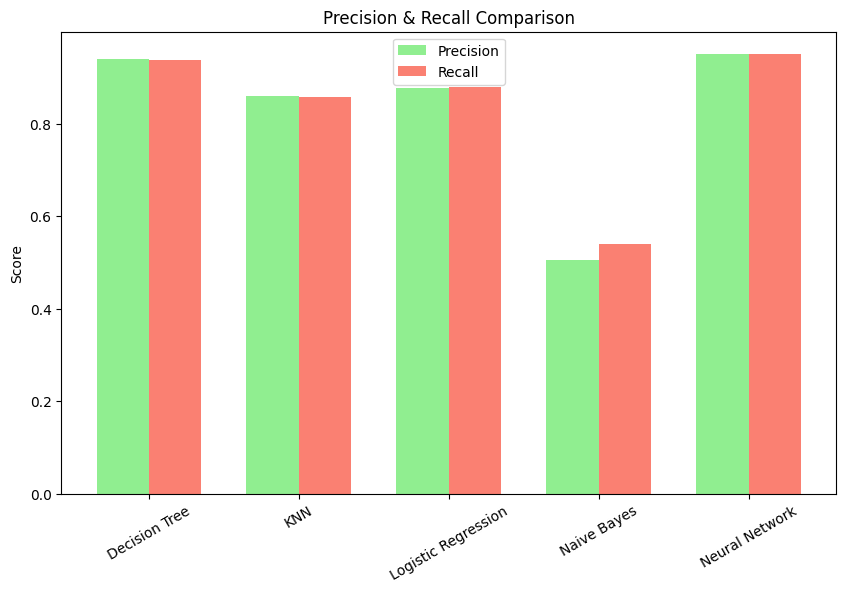

In [58]:
precisions = [dt_precision, knn_precision, log_precision, nb_precision, nn_precision]
recalls    = [dt_recall, knn_recall, log_recall, nb_recall, nn_recall]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, precisions, width, label="Precision", color="lightgreen")
plt.bar(x + width/2, recalls, width, label="Recall", color="salmon")

plt.xticks(x, models, rotation=30)
plt.ylabel("Score")
plt.title("Precision & Recall Comparison")
plt.legend()
plt.show()


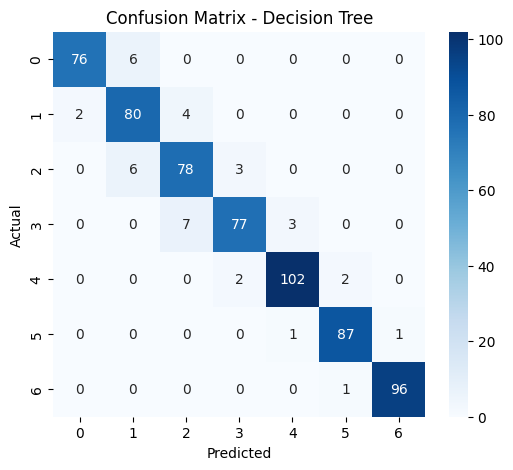

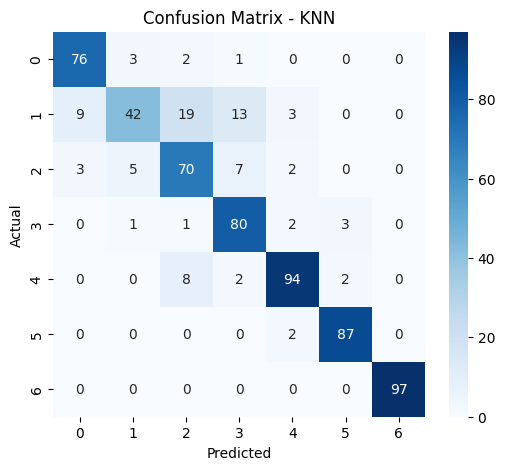

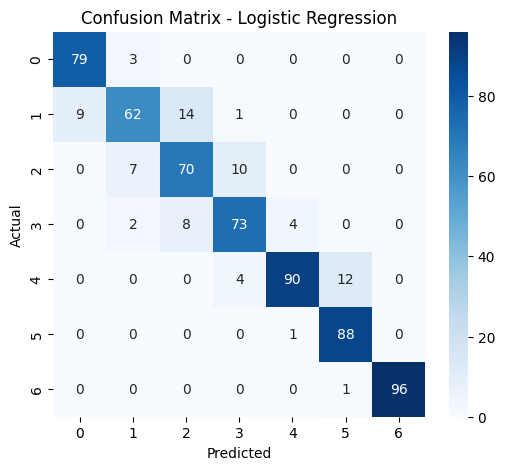

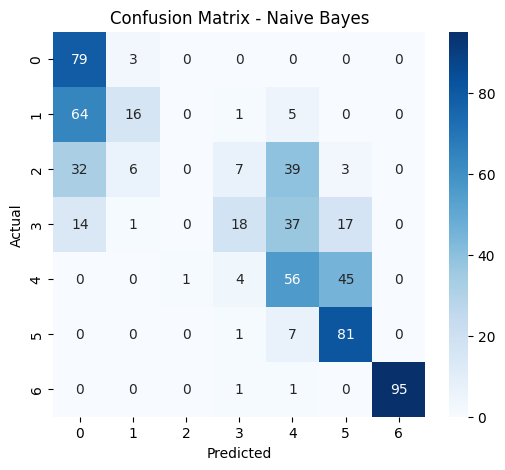

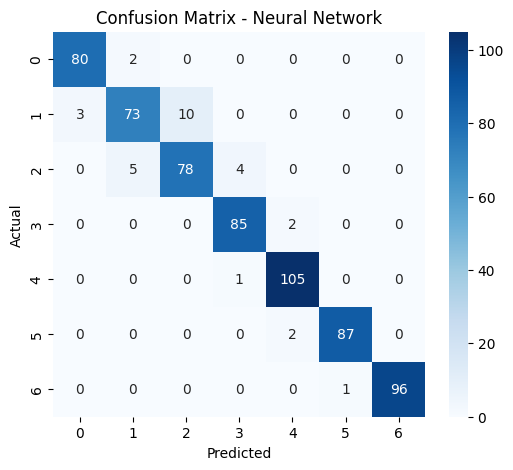

In [59]:
import seaborn as sns

# Decision Tree
plt.figure(figsize=(6,5))
sns.heatmap(dt_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# KNN
plt.figure(figsize=(6,5))
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Logistic Regression
plt.figure(figsize=(6,5))
sns.heatmap(log_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Naive Bayes
plt.figure(figsize=(6,5))
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Neural Network
plt.figure(figsize=(6,5))
sns.heatmap(nn_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


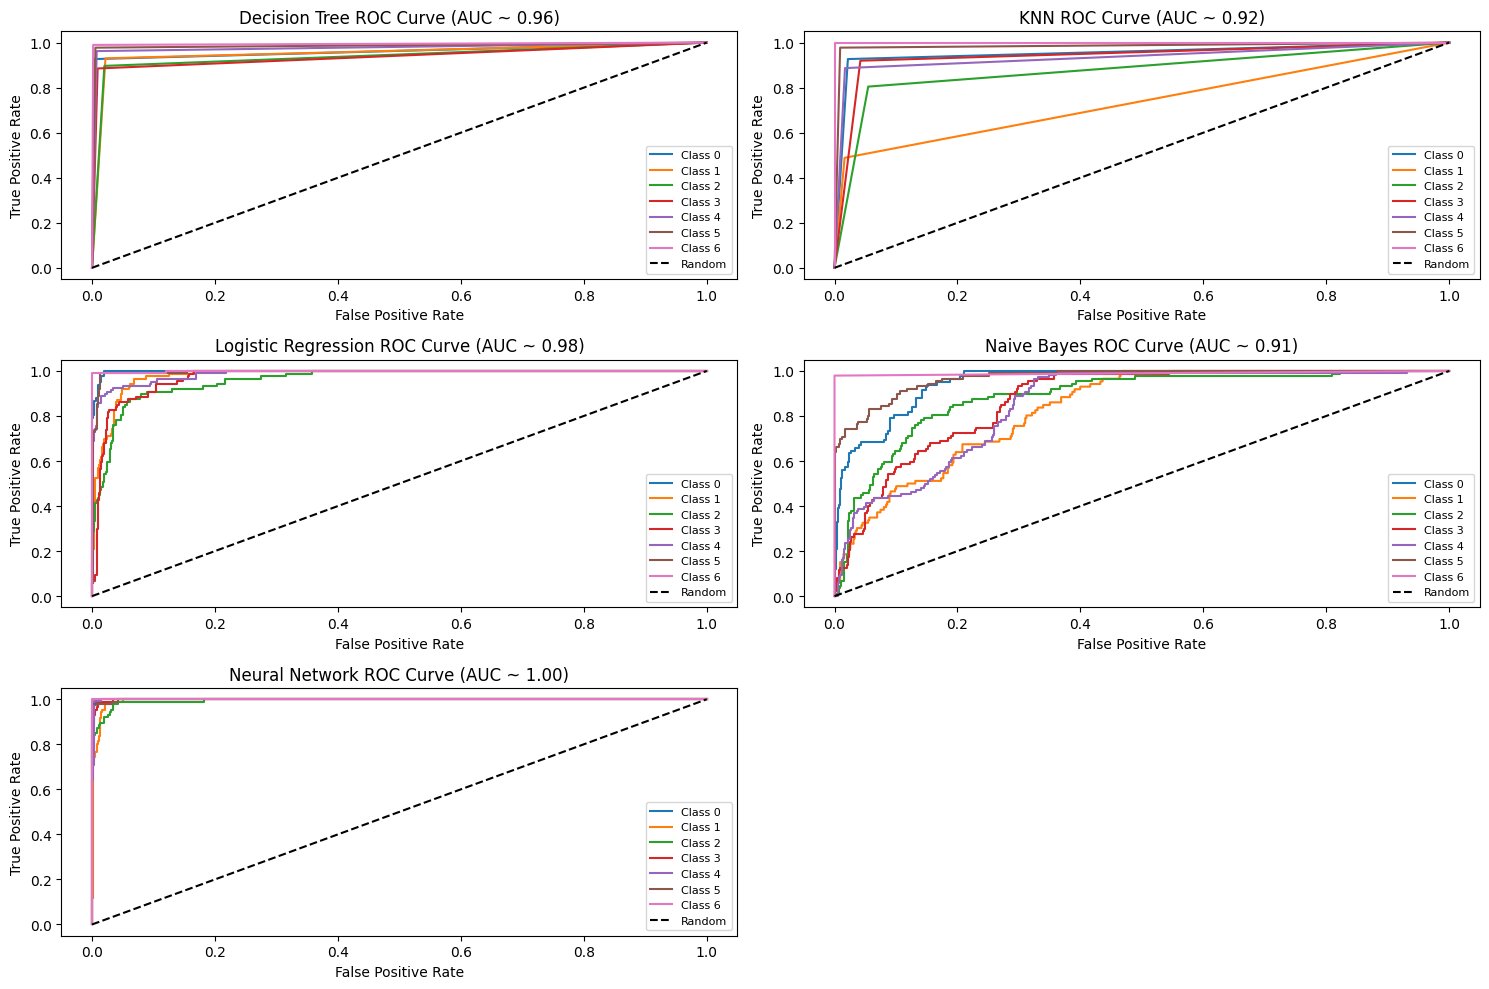

In [60]:
import matplotlib.pyplot as plt

models_roc = {
    "Decision Tree": (dt_fpr, dt_tpr, dt_auc),
    "KNN": (knn_fpr, knn_tpr, knn_auc),
    "Logistic Regression": (log_fpr, log_tpr, log_auc),
    "Naive Bayes": (nb_fpr, nb_tpr, nb_auc),
    "Neural Network": (nn_fpr, nn_tpr, nn_auc)
}

plt.figure(figsize=(15,10))

for idx, (name, (fpr, tpr, auc)) in enumerate(models_roc.items(), 1):
    plt.subplot(3,2,idx)
    for i in fpr:
        plt.plot(fpr[i], tpr[i], label=f"Class {i}")
    plt.plot([0,1], [0,1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC Curve (AUC ~ {auc:.2f})")
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()